# section four

可以考虑不对称的 talnet joint distribution  ps 不必设定下界为1

## imperfect financial market ($\phi=0.5$)

## Setup

In [102]:
# parameters setting
# tech
alpha=0.3
theta=0.49
fc_m=4.68
fc_s=0

# depreciation
delta=0.06

# describing the process for entrepreneurial talent
gamma=0.89
eta=4.84

# discount factor
beta=0.92

# relative risk aversion
sigma=1.5

# intratemporal elasticity of substitution
epsilon=1

# service share in consumption
psi=0.91

# imperfect financial market
phi=0.8

In [103]:
# import packages
import timeit
import numpy as np
from numba import njit,prange
import numba
import matplotlib.pyplot as plt
from scipy.optimize import brentq

In [104]:
# talent probability
from scipy.stats import pareto
def discrete_pareto(shape,lower_bound,upper_bound,grid_numder):
    ability=np.linspace(pareto.ppf(lower_bound,shape),pareto.ppf(upper_bound,shape),(grid_numder+1))  # 可以从60%开始取点，但是没改全！！！
    probability=np.diff(pareto.cdf(ability,shape)) / (upper_bound-lower_bound)
    zgrid = ability[1:]
    return zgrid,probability

In [105]:
kmin = 0
kmax = 250
n_k = 250
kgrid = np.linspace(kmin, kmax, n_k)
sgrid,ps = discrete_pareto(4.84,0.6,0.99,5)
mgrid,pm = discrete_pareto(4.84,0.6,0.9995,20)
# mgrid,p_m = discrete_pareto(4.84,0.6,0.99,20)
n_s = len(sgrid)
n_m = len(mgrid)
V0 = np.zeros((n_k, n_s*n_m))
# joint ditribution (p_s,p_m)
P=np.zeros((n_s*n_m, n_s*n_m))
for i in range(n_s*n_m):
    for j in range(n_s*n_m):
        j_s = j % n_s
        j_m = j // n_s
        if j==i:
            P[i,j]=gamma+(1-gamma)*ps[j_s]*pm[j_m]
        if j!=i:
            P[i,j]=(1-gamma)*ps[j_s]*pm[j_m]

In [106]:
def u(c_s,c_m):
    c = c_s + c_m
    if c > 0:
        # res = (1/(1-sigma))*(psi*c_s**(1-1/epsilon)+(1-psi)*c_m**(1-1/epsilon))**((1-sigma)/(1-1/epsilon))
        res = (1/(1-sigma))*(((c_s)**psi+(c_m)**(1-psi))**(1-sigma))
    else:
        res = -np.inf
    return res
if compile:
    u = njit(u)

def budget_worker(a, x, w, r):
    return w + (1+r)*a - x
if compile:
    budget_worker = njit(budget_worker)

## service
def f_s(z_index, k, l):
    i_s = z_index % n_s
    f = sgrid[i_s]*(k**alpha)*(l**theta)
    return f
if compile:
    f_s = njit(f_s)

@njit
def budget_s(z_index, k, l, a , x , w, r):
    R = r + delta
    return f_s(z_index, k, l) + (1+r)*a - R*k - w*l - x - (1+r)*fc_s

@njit
def capital_constraint_s(k, z_index, a_index , w, r):
    R=r+delta
    i_s = z_index % n_s
    f=phi*(1/theta-1)*w*(theta*sgrid[i_s]*k**alpha/w)**(1/(1-theta))+(1+r)*kgrid[a_index]-R*k-(1+r)*fc_s-(1-phi)*(1-delta)*k
    return f


## manufacture
def f_m(z_index, k, l):
    i_m = z_index // n_s
    f = mgrid[i_m]*(k**alpha)*(l**theta)
    return f
if compile:
    f_m = njit(f_m)

@njit
def budget_m(z_index, k, l, a , x , w, r):
    R = r + delta
    return f_m(z_index, k, l) + (1+r)*a - R*k - w*l - x - (1+r)*fc_m

@njit
def capital_constraint_m(k, z_index, a_index , w, r):
    R=r+delta
    i_m = z_index // n_s
    f=phi*(1/theta-1)*w*(theta*mgrid[i_m]*k**alpha/w)**(1/(1-theta))+(1+r)*kgrid[a_index]-R*k-(1+r)*fc_m-(1-phi)*(1-delta)*k
    return f


In [107]:
# worker
def V_current_worker(k_next_index, k_index, z_index, V_next, w, r, p_s):
    c = budget_worker(kgrid[k_index], kgrid[k_next_index], w, r)
    c_s = c*(p_s+(1-psi)*(1-sigma)/(psi*(1-sigma)))**(-1)
    c_m = c_s*(1-psi)*(1-sigma)/(psi*(1-sigma))
    EV = np.sum(P[z_index,:]*V_next[k_next_index,:]) # expectation
    res = u(c_s,c_m) + beta*(gamma*V_next[k_next_index,z_index]+(1-gamma)*EV)
    return res
if compile:
    V_current_worker = njit(V_current_worker)

def V_max_worker(k_index, z_index, k_start, V, w, r, p_s):
    V_max = -np.inf
    for j in range(k_start,n_k):
        k_next = kgrid[j]
        V_new=V_current_worker(j,k_index,z_index, V, w, r, p_s)
        if V_new > V_max:
            V_max = V_new
            g_k = k_next
            k_start = j
        else:break
    return V_max, g_k, k_start
if compile:
    V_max_worker = njit(V_max_worker)

def V_update_worker(V, w, r, p_s):
    V_new = np.zeros((n_k, n_s*n_m))
    g_new = np.zeros((n_k, n_s*n_m))
    for i_z in prange(n_s*n_m): 
        k_start = 0
        for i_k in range(k_start,n_k): # loop over all state k
            V_new[i_k, i_z], g_new[i_k, i_z] ,k_start= V_max_worker(i_k,i_z,k_start,V,w,r,p_s)
    return V_new, g_new
if compile:
    V_update_worker = njit(V_update_worker, parallel=True)

In [108]:
# 保持 capital_bound_matrix 作为一个纯Python函数  我们只需要加速主线就好了！！！
# 将计算结果作为参数传递：在需要Numba加速的函数中，避免直接调用不可加速的函数，将计算结果（如 bound_matrix 和 opt_matrix）作为参数传递。(从主线剥离)
def m_capital_bound_matrix(w, r):
    bound_matrix = np.zeros((n_k, n_s*n_m))
    for a_index in range(n_k):
        for z_index in range(n_s*n_m):
            i_m = z_index // n_s
            k_max = (((r+delta)+(1-delta)*(1-phi))/((phi*w*(theta*mgrid[i_m]/w)**(1/(1-theta)))*alpha/theta))**(1/((alpha/(1-theta))-1))
            res = capital_constraint_m(k_max, z_index, a_index , w, r)
            if res < 0 :
                bound_matrix[a_index,z_index]=0
            if res == 0 :
                bound_matrix[a_index,z_index]=k_max
            if res > 0 :
                solution = brentq(capital_constraint_m, k_max,1e+10, args=(z_index, a_index, w, r))
                bound_matrix[a_index,z_index] = solution
            # print(k_max)
    return  bound_matrix
    
def s_capital_bound_matrix(w, r):
    bound_matrix = np.zeros((n_k, n_s*n_m))
    for a_index in range(n_k):
        for z_index in range(n_s*n_m):
            i_s = z_index % n_s
            k_max = (((r+delta)+(1-delta)*(1-phi))/((phi*w*(theta*sgrid[i_s]/w)**(1/(1-theta)))*alpha/theta))**(1/((alpha/(1-theta))-1))
            res = capital_constraint_s(k_max, z_index, a_index , w, r)
            if res < 0 :
                bound_matrix[a_index,z_index]=0
            if res == 0 :
                bound_matrix[a_index,z_index]=k_max
            if res > 0 :
                solution = brentq(capital_constraint_s, k_max,1e+10, args=(z_index, a_index, w, r))
                bound_matrix[a_index,z_index] = solution
            # print(k_max)
    return  bound_matrix
    

In [109]:
bound_matrix_s = s_capital_bound_matrix(0.7,0.08)
bound_matrix_m = m_capital_bound_matrix(0.7,0.08)

In [110]:
bound_matrix_s

array([[   4.85300686,   10.93675995,   21.88970051, ...,   21.88970051,
          40.10628097,   68.62568317],
       [  11.27368879,   17.93705147,   29.28149124, ...,   29.28149124,
          47.74177407,   76.40773381],
       [  16.62492312,   23.9590559 ,   35.89123731, ...,   35.89123731,
          54.80408837,   83.78819652],
       ...,
       [ 922.89543543,  969.51799978, 1027.13501119, ..., 1027.13501119,
        1097.50326072, 1182.82911159],
       [ 926.44149258,  973.16180805, 1030.89388117, ..., 1030.89388117,
        1101.39471271, 1186.87067424],
       [ 929.98714413,  976.80504269, 1034.65197871, ..., 1034.65197871,
        1105.28516305, 1190.91097731]])

In [111]:
bound_matrix_m

array([[   0.        ,    0.        ,    0.        , ..., 1269.99939451,
        1269.99939451, 1269.99939451],
       [   0.        ,    0.        ,    0.        , ..., 1278.15383285,
        1278.15383285, 1278.15383285],
       [   0.        ,    0.        ,    0.        , ..., 1286.27707398,
        1286.27707398, 1286.27707398],
       ...,
       [ 892.58116801,  892.58116801,  892.58116801, ..., 2883.23114949,
        2883.23114949, 2883.23114949],
       [ 896.09886594,  896.09886594,  896.09886594, ..., 2888.97666675,
        2888.97666675, 2888.97666675],
       [ 899.61619995,  899.61619995,  899.61619995, ..., 2894.71871646,
        2894.71871646, 2894.71871646]])

In [112]:
# service
@njit
def s_capital_opt_unconditional(k_index, z_index, w, r):
    R = r + delta
    i_s = z_index % n_s
    opt = ((R / alpha / sgrid[i_s]) * (w * alpha / R / theta) ** theta) ** (1 / (alpha + theta - 1))
    return opt

@njit
def s_capital_demand(k_index, z_index, w, r, bound_matrix):
    if bound_matrix[k_index, z_index] > s_capital_opt_unconditional(k_index, z_index, w, r):
        capital_demand = s_capital_opt_unconditional(k_index, z_index, w, r)
    else:
        capital_demand = bound_matrix[k_index, z_index]
    return capital_demand


@njit
def s_V_current_entrepreneur(k_next_index, k_index, z_index, V_next, w, r,  p_s, bound_matrix):
    R = r + delta
    i_s = z_index % n_s
    # k_matrix = s_capital_demand_matrix(w, r, bound_matrix)
    k = s_capital_demand(k_index, z_index, w, r, bound_matrix)
    l = (theta*sgrid[i_s]*(k**alpha)/w)**(1/(1-theta))
    c = budget_s(z_index, k, l, kgrid[k_index], kgrid[k_next_index], w, r)
    c_s = c*(p_s+(1-psi)*(1-sigma)/(psi*(1-sigma)))**(-1)
    c_m = c_s*(1-psi)*(1-sigma)/(psi*(1-sigma))
    EV = np.sum(P[z_index, :] * V_next[k_next_index, :])  # expectation
    res = u(c_s,c_m) + beta * (gamma * V_next[k_next_index, z_index] + (1 - gamma) * EV)
    return res

@njit
def s_V_max_entrepreneur(k_index, z_index, k_start, V, w, r, p_s, bound_matrix):
    V_max = -np.inf
    for j in range(k_start, n_k):
        k_next = kgrid[j]
        V_new = s_V_current_entrepreneur(j, k_index, z_index, V, w, r, p_s, bound_matrix)
        if V_new > V_max:
            V_max = V_new
            g_k = k_next
            k_start = j
        else:
            break
    return V_max, g_k, k_start

In [113]:
# manufacture
@njit
def m_capital_opt_unconditional(k_index, z_index, w, r):
    R = r + delta
    i_m = z_index // n_s
    opt = ((R / alpha / mgrid[i_m]) * (w * alpha / R / theta) ** theta) ** (1 / (alpha + theta - 1))
    return opt

@njit
def m_capital_demand(k_index, z_index, w, r, bound_matrix):
    if bound_matrix[k_index, z_index] > m_capital_opt_unconditional(k_index, z_index, w, r):
        capital_demand = m_capital_opt_unconditional(k_index, z_index, w, r)
    else:
        capital_demand = bound_matrix[k_index, z_index]
    return capital_demand

@njit
def m_V_current_entrepreneur(k_next_index, k_index, z_index, V_next, w, r,  p_s, bound_matrix):
    R = r + delta
    i_m = z_index // n_s
    # k_matrix = m_capital_demand_matrix(w, r, bound_matrix)
    k = m_capital_demand(k_index, z_index, w, r, bound_matrix)
    l = (theta*mgrid[i_m]*(k**alpha)/w)**(1/(1-theta))
    c = budget_m(z_index, k, l, kgrid[k_index], kgrid[k_next_index], w, r)
    c_s = c*(p_s+(1-psi)*(1-sigma)/(psi*(1-sigma)))**(-1)
    c_m = c_s*(1-psi)*(1-sigma)/(psi*(1-sigma))
    EV = np.sum(P[z_index, :] * V_next[k_next_index, :])  # expectation
    res = u(c_s,c_m) + beta * (gamma * V_next[k_next_index, z_index] + (1 - gamma) * EV)
    return res

@njit
def m_V_max_entrepreneur(k_index, z_index, k_start, V, w, r, p_s, bound_matrix):
    V_max = -np.inf
    for j in range(k_start, n_k):
        k_next = kgrid[j]
        V_new = m_V_current_entrepreneur(j, k_index, z_index, V, w, r, p_s, bound_matrix)
        if V_new > V_max:
            V_max = V_new
            g_k = k_next
            k_start = j
        else:
            break
    return V_max, g_k, k_start


## Iterate together

In [114]:
def V_update(V, w, r, p_s, bound_matrix_s, bound_matrix_m):
    V_new = np.zeros((n_k, n_s*n_m))
    g_new = np.zeros((n_k, n_s*n_m))
    state_manufacture = np.zeros((n_k, n_s*n_m))
    state_service = np.zeros((n_k, n_s*n_m))
    # V_worker,g_worker=V_update_worker(V, w, r, p_s)
    # V_manufacture,g_manufacture=m_V_update_entrepreneur(V, w, r, p_s, bound_matrix_m)
    # V_service,g_service=s_V_update_entrepreneur(V, w, r, p_s, bound_matrix_s)
    for i_z in prange(n_s*n_m):
        k_start_worker=0
        k_start_manufacture=0
        k_start_service=0
        for i_k in range(n_k):
            V_new_worker, g_new_worker,k_start_worker= V_max_worker(i_k, i_z, k_start_worker, V, w, r, p_s)
            V_new_manufacture, g_new_manufacture,k_start_manufacture= m_V_max_entrepreneur(i_k, i_z, k_start_manufacture, V, w, r, p_s, bound_matrix_m)
            V_new_service, g_new_service,k_start_service= s_V_max_entrepreneur(i_k, i_z, k_start_service, V, w, r, p_s, bound_matrix_s)
            if V_new_service> V_new_manufacture and V_new_service > V_new_worker:
                V_new[i_k, i_z]=V_new_service
                g_new[i_k, i_z]=g_new_service
                state_service[i_k, i_z]=1
            if V_new_manufacture > V_new_service and V_new_manufacture > V_new_worker:
                V_new[i_k, i_z]=V_new_manufacture
                g_new[i_k, i_z]=g_new_manufacture
                state_manufacture[i_k, i_z]=1
            else:
                V_new[i_k, i_z]=V_new_worker
                g_new[i_k, i_z]=g_new_worker
    return V_new, g_new, state_manufacture, state_service #,np.sum(state_manufacture), np.sum(state_service)
if compile:
    V_update = njit(V_update,parallel=True)

def V_iteration(V_initial,tol,w,r,p_s, bound_matrix_s, bound_matrix_m):
    V = V_initial
    error = np.inf
    count = 0
    max_iter = 1000
    print_skip = 50
    while count < max_iter and error > tol:
        V_new, g_new, state_manufacture, state_service = V_update(V, w, r,p_s, bound_matrix_s, bound_matrix_m)
        error = np.max(np.abs(V_new - V))
        V = V_new
        count = count + 1
        # if count % print_skip == 0:
            # print(f"Error at iteration {count} is {error}.")
    # if error > tol:
    #     print("Failed to converge!")
    # else:
    #      print(f"\nConverged in {count} iterations.")
    return V_new, g_new, state_manufacture , state_service

In [115]:
%%time
V_update(V0, 0.7, 0.08, 1.2, bound_matrix_s, bound_matrix_m)

CPU times: total: 11 s
Wall time: 11.1 s


(array([[-1.72913853, -1.72913853, -1.72913853, ..., -0.1572787 ,
         -0.1572787 , -0.1572787 ],
        [-1.35750418, -1.35750418, -1.35750418, ..., -0.15688188,
         -0.15688188, -0.15688188],
        [-1.16869658, -1.16869658, -1.16869658, ..., -0.15648995,
         -0.15648995, -0.15648995],
        ...,
        [-0.17591342, -0.17591342, -0.17591342, ..., -0.11313972,
         -0.11313972, -0.11313972],
        [-0.1755941 , -0.1755941 , -0.1755941 , ..., -0.11304776,
         -0.11304776, -0.11304776],
        [-0.17527662, -0.17527662, -0.17527662, ..., -0.11295611,
         -0.11295611, -0.11295611]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
       

In [116]:
start_time = timeit.default_timer()
V, g ,  state_manufacture , state_service= V_iteration(V_initial=V0,tol=1e-7,w=0.7,r=0.05,p_s=1.2,bound_matrix_s=bound_matrix_s,bound_matrix_m=bound_matrix_m)
print("The time difference is :", timeit.default_timer() - start_time)

The time difference is : 10.093655100034084


Text(0, 0.5, '$k_{t+1}$')

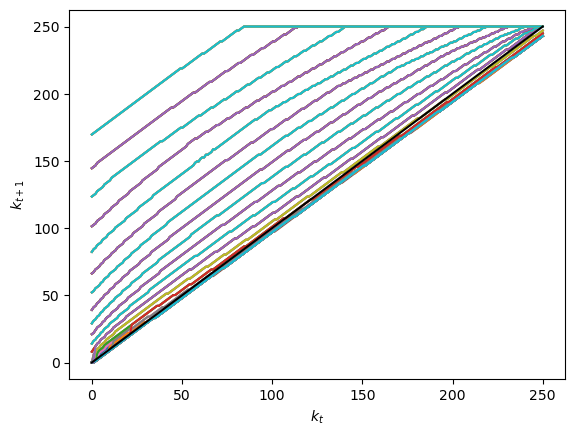

In [117]:
for i in range (n_s*n_m):
    plt.plot(kgrid,g[:,i],label='z_m='+ str(mgrid[i // n_s])+ ',' +'z_s='+ str(sgrid[i % n_s]))
plt.plot(kgrid,kgrid,label="45 degree",color='black')
plt.xlabel("$k_t$")
plt.ylabel("$k_{t+1}$")
# plt.title('policy function,$w=0.7,r=0.05,p=2$')
# plt.legend()

Text(0, 0.5, '$V$')

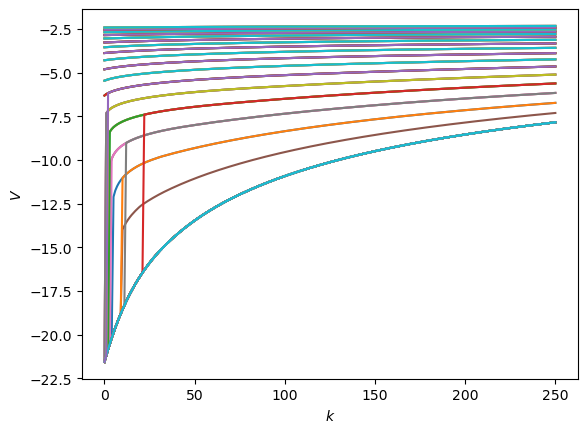

In [118]:
for i in range (n_s*n_m):
    plt.plot(kgrid,V[:,i],label='z_m='+ str(mgrid[i // n_s])+ ',' +'z_s='+ str(sgrid[i % n_s]))
plt.xlabel("$k$")
plt.ylabel("$V$")
# plt.title('policy function,$w=0.7,r=0.05,p=2$')
# plt.legend()

In [119]:
state_manufacture

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [120]:
np.sum(state_manufacture)

18420.0

In [121]:
state_service

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [122]:
np.sum(state_service)

6580.0

In [123]:
n_k*n_m*n_s-np.sum(state_service)-np.sum(state_manufacture)

0.0

In [124]:

from scipy import sparse

def transQ_sparse(g):
    n_k, n_s = g.shape
    n = n_k * n_s
    row_indices = []
    col_indices = []
    values = []

    for j in numba.prange(n):
        i_k = j // n_s
        i_s = j % n_s
        diff = np.abs(g[i_k, i_s] - kgrid)
        mark = np.argmin(diff)
        j_prime_start = mark * n_s
        
        row = np.full(n_s, j)
        col = np.arange(j_prime_start, j_prime_start + n_s)
        val = P[i_s, :]
        
        row_indices.extend(row)
        col_indices.extend(col)
        values.extend(val)

    Q = sparse.csr_matrix((values, (row_indices, col_indices)), shape=(n, n))
    return Q

In [125]:
# # Asset's Stable Distribution
# # 用稀疏矩阵加速(待定)
# def transQ(g):
#     n_k, n_z = g.shape
#     n = n_k * n_z
#     Q = np.zeros((n, n))
#     for j in range(n):
#         i_k = j // n_z
#         i_s = j % n_z
#         diff = np.abs(g[i_k, i_s] - kgrid)
#         mark = np.argmin(diff)
#         j_prime_start = mark * n_z
#         j_prime_end = j_prime_start + n_z
#         Q[j, j_prime_start:j_prime_end] = P[i_s, :]
#     return Q
# # if compile:
# #     transQ=njit(transQ,parallel=True)

# @njit
def capital_marginal(joint_dist):
    tmp = joint_dist.reshape((n_k, n_s*n_m))
    k_marginal = tmp.sum(axis=1)
    return k_marginal
# @njit
def state_marginal(joint_dist):
    tmp = joint_dist.reshape((n_k, n_s*n_m))
    s_marginal = tmp.sum(axis=0)
    return s_marginal

# 0是列(given z)，1是行(given k)

In [126]:
import scipy.sparse as sp

def sparse_stationary_distribution_iteration(P, psi0, tol):
    P_csc = sp.csc_matrix(P.T)
    err = np.inf
    max_iter = 1000
    iter = 0
    print_skip = 50
    
    while iter < max_iter and err > tol:
        psi = P_csc.dot(psi0)
        err = np.max(np.abs(psi - psi0))
        iter = iter + 1
        psi0 = psi
        
    return psi0


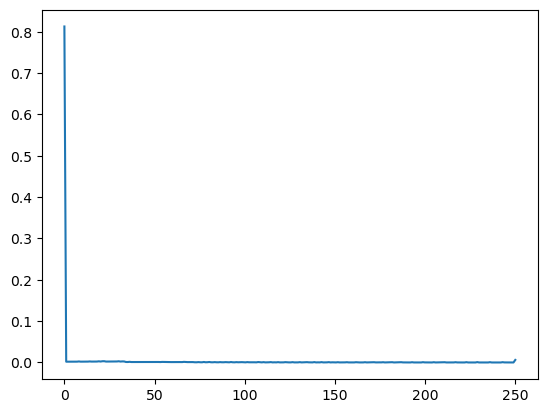

In [127]:
psi0 = np.ones((n_k * n_s*n_m))/(n_k * n_s*n_m)
QQ=transQ_sparse(g)
# Q = transQ(g)
# start_time = timeit.default_timer()
ss = sparse_stationary_distribution_iteration(QQ, psi0, tol=1e-5)
# print("The time difference is :", timeit.default_timer() - start_time)
a_dist=capital_marginal(ss)
plt.plot(kgrid,a_dist)

In [128]:
# Compute Demand and Supply in Capital Market
def capital_and_labor_and_service(w,r,p_s):
    # initialize
    # start_time = timeit.default_timer()
    bound_matrix_s = s_capital_bound_matrix(w,r)
    bound_matrix_m = m_capital_bound_matrix(w,r)
    V0 = np.zeros((n_k, n_s*n_m))
    # iteration
    V_new,g,state_manufacture,state_service=V_iteration(V0,1e-7,w,r,p_s,bound_matrix_s,bound_matrix_m)
    # print("The time difference is :", timeit.default_timer() - start_time)
    # stable distribution
    Q=transQ_sparse(g)
    psi0 = np.ones((n_k * n_s*n_m))/(n_k * n_s*n_m)
    ss=sparse_stationary_distribution_iteration(Q,psi0,1e-4)
    tmp = ss.reshape((n_k, n_s*n_m))
    # a_dist=capital_marginal(ss)
    # compute demand and supply
    # capital_supply=np.dot(kgrid,a_dist)
    state_worker=np.ones((n_k, n_s*n_m))-state_manufacture-state_service
    R=r+delta
    # l = np.sum(state_worker*tmp)
    capital_supply_joint= np.zeros((n_k, n_s*n_m))
    capital_demand_joint= np.zeros((n_k, n_s*n_m))
    labor_supply_joint=np.zeros((n_k, n_s*n_m))
    labor_demand_joint= np.zeros((n_k, n_s*n_m))
    service_demand_joint = np.zeros((n_k, n_s*n_m))
    service_supply_joint = np.zeros((n_k, n_s*n_m))
    for i_k in range(n_k):
        for i_z in range(n_s*n_m):
            capital_supply_joint[i_k,i_z]=tmp[i_k,i_z]*g[i_k,i_z]
            labor_supply_joint[i_k,i_z] = state_worker[i_k,i_z]*tmp[i_k,i_z]
            i_s = i_z % n_s
            i_m = i_z // n_s
            k_m=m_capital_demand(i_k, i_z, w, r, bound_matrix_m)*state_manufacture[i_k,i_z]
            k_s=s_capital_demand(i_k, i_z, w, r, bound_matrix_s)*state_service[i_k,i_z]
            capital_demand_joint[i_k,i_z] = (k_m+k_s)*tmp[i_k,i_z]
            l_m = (theta*mgrid[i_m]*(k_m**alpha)/w)**(1/(1-theta))
            l_s = (theta*sgrid[i_s]*(k_s**alpha)/w)**(1/(1-theta))
            labor_demand_joint[i_k,i_z] = (l_m+l_s)*tmp[i_k,i_z]
            # service_demand_joint[i_k,i_z]=budget_worker(kgrid[i_k], g[i_k,i_z], w, r)*((p_s+((1-psi)/psi))**(-1))*tmp[i_k,i_z]
            service_demand_joint[i_k,i_z]=((p_s+((1-psi)/psi))**(-1))*tmp[i_k,i_z]*(budget_worker(kgrid[i_k], g[i_k,i_z], w, r)*state_worker[i_k,i_z]+budget_s(i_z,k_s,l_s,kgrid[i_k],g[i_k,i_z],w,r)*state_service[i_k,i_z]+budget_m(i_z,k_m,l_m,kgrid[i_k],g[i_k,i_z],w,r)*state_manufacture[i_k,i_z])
            service_supply_joint[i_k,i_z]=state_service[i_k,i_z]*tmp[i_k,i_z]*f_s(i_z,k_s,l_s)
    capital_supply=np.sum(capital_supply_joint)
    labor_supply=np.sum(labor_supply_joint)
    k_demand=np.sum(capital_demand_joint)
    l_demand=np.sum(labor_demand_joint)
    service_demand=np.sum(service_demand_joint)
    service_supply=np.sum(service_supply_joint)
    return capital_supply,k_demand,labor_supply,l_demand,service_supply,service_demand


In [150]:
capital_and_labor_and_service(1.45,0.082,10)

(74.41619661549637,
 5.3715686595804115,
 0.9237940426531466,
 0.8614432661464757,
 0.8602332396714448,
 0.779771370013178)

## solve equilibrium price $(w,r)$

In [157]:
def equilibrium_k(w,r,p_s):
    a_supply,a_demand,l_supply,l_demand,s_supply,s_demand=capital_and_labor_and_service(w,r,p_s)
    res_k=a_supply-a_demand
    print('w=',w,'r=',r,'p_s=',p_s,'capital supply=',a_supply,'capital demand=',a_demand,'res_k=',res_k)
    return res_k
    
def equilibrium_l(w,r,p_s):
    a_supply,a_demand,l_supply,l_demand,s_supply,s_demand=capital_and_labor_and_service(w,r,p_s)
    res_l=l_supply-l_demand
    print('w=',w,'r=',r,'p_s=',p_s,'labor suply=',l_supply,'labor demand=',l_demand,'res_l=',res_l)
    return res_l

def equilibrium_s(w,r,p_s):
    a_supply,a_demand,l_supply,l_demand,s_supply,s_demand=capital_and_labor_and_service(w,r,p_s)
    res_s=s_supply-s_demand
    print('w=',w,'r=',r,'p_s=',p_s,'service suply=',s_supply,'service demand=',s_demand,'res_s=',res_s)
    return res_s

In [158]:
## plot
from tqdm import tqdm

def labor_curve(wmin, wmax, wgrid_number,r,p_s):
    wgrid = np.linspace(wmin, wmax, wgrid_number)
    l_supply = np.zeros(wgrid_number)
    l_demand = np.zeros(wgrid_number)
    for i in tqdm(range(wgrid_number)):
        w0 = wgrid[i]
        capital_supply,capital_demand,l_supply[i],l_demand[i],service_supply,service_demand=capital_and_labor_and_service(w0,r,p_s) #capital 只是为了占位
    return wgrid, l_supply, l_demand

wgrid, labor_supply, labor_demand = labor_curve(
    wmin=0.7, wmax=1.7, wgrid_number=21,r=0.082,p_s=10
)

100%|██████████| 21/21 [04:29<00:00, 12.84s/it]


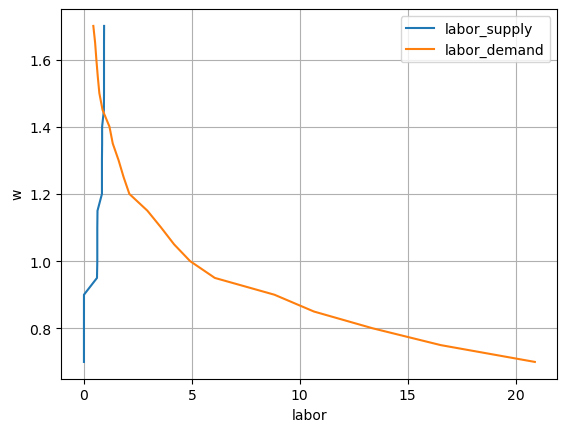

In [159]:
# Plot
plt.plot(labor_supply,wgrid,label="labor_supply")
plt.plot(labor_demand,wgrid,label="labor_demand")
# plt.title('labor market with r=0.08')
plt.ylabel('w')
plt.xlabel('labor')
# plt.xlim([-0.1,20])
plt.legend()
plt.grid(True)

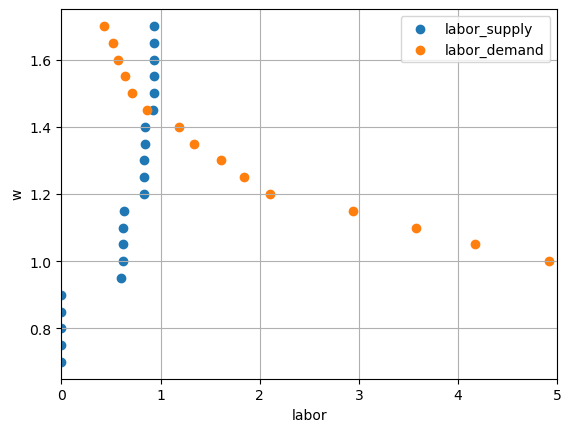

In [160]:
# Plot
plt.scatter(labor_supply,wgrid,label="labor_supply")
plt.scatter(labor_demand,wgrid,label="labor_demand")
# plt.title('labor market with r=0.08')
plt.ylabel('w')
plt.xlabel('labor')
# plt.ylim([1,1.2])
plt.xlim(0,5)
plt.legend()
plt.grid(True)

In [153]:
def w_update(r,p_s,tol):
    wmax=1.6
    wmin=1.2
    w0=1/2*(wmin+wmax)
    error = np.inf
    count = 0
    max_iter = 1000
    print_skip = 50
    while count < max_iter and error > tol:
        res = equilibrium_l(w0,r,p_s)
        if res < 0:
            wmin=w0
        else:
            wmax=w0
        w0=1/2*(wmin+wmax)
        error = np.abs(wmax-wmin)
        count = count + 1
    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {count} iterations.")
    print("final w=", w0)
    return w0

In [154]:
from tqdm import tqdm
# capital 之前 工资要稳定：劳动力市场要出清
def capital_curve(rmin, rmax, rgrid_number, p_s):
    rgrid = np.linspace(rmin, rmax, rgrid_number)
    a_supply = np.zeros(rgrid_number)
    a_demand = np.zeros(rgrid_number)
    for i in tqdm(range(rgrid_number)):
        r0 = rgrid[i]
        w = w_update(r0,p_s,1e-3)
        a_supply[i],a_demand[i],l_supply,l_demand,s_supply,s_demand=capital_and_labor_and_service(w,r0,p_s) #labor 只是为了占位
    return rgrid, a_supply, a_demand

rgrid, k_supply, k_demand = capital_curve(
    rmin=0.03, rmax=0.082, rgrid_number=20,p_s=10
)


  0%|          | 0/20 [00:00<?, ?it/s]

w= 1.4 r= 0.03 p_s= 10 labor suply= 0.8477513881767671 labor demand= 0.9246513366775329 res_l= -0.07689994850076576
w= 1.5 r= 0.03 p_s= 10 labor suply= 0.9362844975178999 labor demand= 0.5643293809448973 res_l= 0.3719551165730026
w= 1.45 r= 0.03 p_s= 10 labor suply= 0.854220540665091 labor demand= 0.7479758038116285 res_l= 0.10624473685346247
w= 1.4249999999999998 r= 0.03 p_s= 10 labor suply= 0.8506017261173519 labor demand= 0.8034724096193836 res_l= 0.047129316497968254
w= 1.4124999999999999 r= 0.03 p_s= 10 labor suply= 0.8505438614559949 labor demand= 0.827954001887648 res_l= 0.022589859568346915
w= 1.40625 r= 0.03 p_s= 10 labor suply= 0.850101795444277 labor demand= 0.8464746147731848 res_l= 0.003627180671092245
w= 1.403125 r= 0.03 p_s= 10 labor suply= 0.847771069587726 labor demand= 0.9175035541024941 res_l= -0.0697324845147681
w= 1.4046875 r= 0.03 p_s= 10 labor suply= 0.847775486304761 labor demand= 0.9140898154163158 res_l= -0.06631432911155488
w= 1.40546875 r= 0.03 p_s= 10 labor

  5%|▌         | 1/20 [02:20<44:21, 140.08s/it]

w= 1.4 r= 0.032736842105263154 p_s= 10 labor suply= 0.8504523808070698 labor demand= 0.8363790122724761 res_l= 0.014073368534593622
w= 1.2999999999999998 r= 0.032736842105263154 p_s= 10 labor suply= 0.846805621318292 labor demand= 1.1735096304198178 res_l= -0.32670400910152586
w= 1.3499999999999999 r= 0.032736842105263154 p_s= 10 labor suply= 0.8474066636923706 labor demand= 1.0297878757224388 res_l= -0.18238121203006818
w= 1.375 r= 0.032736842105263154 p_s= 10 labor suply= 0.8475649363193227 labor demand= 0.965134307297091 res_l= -0.11756937097776832
w= 1.3875 r= 0.032736842105263154 p_s= 10 labor suply= 0.8476582042122852 labor demand= 0.935507418055219 res_l= -0.08784921384293376
w= 1.3937499999999998 r= 0.032736842105263154 p_s= 10 labor suply= 0.8476273389115667 labor demand= 0.9213238434589854 res_l= -0.07369650454741872
w= 1.3968749999999999 r= 0.032736842105263154 p_s= 10 labor suply= 0.850242455788284 labor demand= 0.8485676004088026 res_l= 0.0016748553794813104
w= 1.395312499

 10%|█         | 2/20 [04:28<39:57, 133.22s/it]

w= 1.4 r= 0.03547368421052632 p_s= 10 labor suply= 0.8541073935711735 labor demand= 0.8113714546375872 res_l= 0.04273593893358629
w= 1.2999999999999998 r= 0.03547368421052632 p_s= 10 labor suply= 0.8467188196302394 labor demand= 1.1514741052233766 res_l= -0.30475528559313714
w= 1.3499999999999999 r= 0.03547368421052632 p_s= 10 labor suply= 0.8472230683492059 labor demand= 1.0102774126521954 res_l= -0.16305434430298948
w= 1.375 r= 0.03547368421052632 p_s= 10 labor suply= 0.847425987987666 labor demand= 0.9468702785621868 res_l= -0.09944429057452076
w= 1.3875 r= 0.03547368421052632 p_s= 10 labor suply= 0.8500652644584984 labor demand= 0.851918607531122 res_l= -0.0018533430726236366
w= 1.3937499999999998 r= 0.03547368421052632 p_s= 10 labor suply= 0.8540980719952447 labor demand= 0.8248069466502579 res_l= 0.02929112534498679
w= 1.390625 r= 0.03547368421052632 p_s= 10 labor suply= 0.8502943609534381 labor demand= 0.8398525042901527 res_l= 0.010441856663285454
w= 1.3890625 r= 0.035473684210

 15%|█▌        | 3/20 [06:31<36:24, 128.53s/it]

w= 1.4 r= 0.03821052631578947 p_s= 10 labor suply= 0.8541779846483091 labor demand= 0.7950511419391113 res_l= 0.05912684270919777
w= 1.2999999999999998 r= 0.03821052631578947 p_s= 10 labor suply= 0.8464650454676221 labor demand= 1.129879369079648 res_l= -0.2834143236120259
w= 1.3499999999999999 r= 0.03821052631578947 p_s= 10 labor suply= 0.8471200712643641 labor demand= 0.9901520934684468 res_l= -0.14303202220408273
w= 1.375 r= 0.03821052631578947 p_s= 10 labor suply= 0.8475119328730163 labor demand= 0.9273813312763111 res_l= -0.07986939840329477
w= 1.3875 r= 0.03821052631578947 p_s= 10 labor suply= 0.8541064248845422 labor demand= 0.8208732677350443 res_l= 0.03323315714949793
w= 1.38125 r= 0.03821052631578947 p_s= 10 labor suply= 0.854098378474234 labor demand= 0.8340574924767135 res_l= 0.02004088599752052
w= 1.378125 r= 0.03821052631578947 p_s= 10 labor suply= 0.8539382201123624 labor demand= 0.845244104451435 res_l= 0.00869411566092737
w= 1.3765625 r= 0.03821052631578947 p_s= 10 lab

 20%|██        | 4/20 [08:46<34:56, 131.05s/it]

w= 1.4 r= 0.040947368421052635 p_s= 10 labor suply= 0.8542121381245212 labor demand= 0.7794913882998369 res_l= 0.07472074982468435
w= 1.2999999999999998 r= 0.040947368421052635 p_s= 10 labor suply= 0.8463391281449818 labor demand= 1.1083243566251213 res_l= -0.2619852284801395
w= 1.3499999999999999 r= 0.040947368421052635 p_s= 10 labor suply= 0.8469997910226297 labor demand= 0.9712840708241036 res_l= -0.12428427980147394
w= 1.375 r= 0.040947368421052635 p_s= 10 labor suply= 0.8541545241819526 labor demand= 0.829936436624872 res_l= 0.024218087557080548
w= 1.3624999999999998 r= 0.040947368421052635 p_s= 10 labor suply= 0.8522115534201934 labor demand= 0.9263747134926325 res_l= -0.07416316007243906
w= 1.36875 r= 0.040947368421052635 p_s= 10 labor suply= 0.8539451438906062 labor demand= 0.8479944034429918 res_l= 0.005950740447614344
w= 1.3656249999999999 r= 0.040947368421052635 p_s= 10 labor suply= 0.8522208692328017 labor demand= 0.9186968610067258 res_l= -0.06647599177392405
w= 1.3671875 

 25%|██▌       | 5/20 [11:22<35:01, 140.11s/it]

w= 1.4 r= 0.04368421052631579 p_s= 10 labor suply= 0.8543566810769774 labor demand= 0.7633170593481997 res_l= 0.09103962172877766
w= 1.2999999999999998 r= 0.04368421052631579 p_s= 10 labor suply= 0.8460929495696651 labor demand= 1.0876605277902294 res_l= -0.2415675782205643
w= 1.3499999999999999 r= 0.04368421052631579 p_s= 10 labor suply= 0.8522043482768418 labor demand= 0.9372877583076217 res_l= -0.0850834100307799
w= 1.375 r= 0.04368421052631579 p_s= 10 labor suply= 0.8541609587328403 labor demand= 0.8135817978872741 res_l= 0.04057916084556612
w= 1.3624999999999998 r= 0.04368421052631579 p_s= 10 labor suply= 0.8541397914921931 labor demand= 0.839906379935934 res_l= 0.014233411556259123
w= 1.3562499999999997 r= 0.04368421052631579 p_s= 10 labor suply= 0.8522762076949023 labor demand= 0.9215266431486995 res_l= -0.06925043545379717
w= 1.3593749999999998 r= 0.04368421052631579 p_s= 10 labor suply= 0.8539841481713294 labor demand= 0.8512819893068222 res_l= 0.002702158864507198
w= 1.357812

 30%|███       | 6/20 [13:39<32:25, 138.96s/it]

w= 1.4 r= 0.046421052631578946 p_s= 10 labor suply= 0.854362321836582 labor demand= 0.7478613678740914 res_l= 0.1065009539624906
w= 1.2999999999999998 r= 0.046421052631578946 p_s= 10 labor suply= 0.8461416355259375 labor demand= 1.066681018514156 res_l= -0.2205393829882185
w= 1.3499999999999999 r= 0.046421052631578946 p_s= 10 labor suply= 0.8539705911497542 labor demand= 0.855788517496579 res_l= -0.0018179263468248719
w= 1.375 r= 0.046421052631578946 p_s= 10 labor suply= 0.8543314493822608 labor demand= 0.7967878740195621 res_l= 0.05754357536269872
w= 1.3624999999999998 r= 0.046421052631578946 p_s= 10 labor suply= 0.8541500489740141 labor demand= 0.8241474395415067 res_l= 0.030002609432507432
w= 1.3562499999999997 r= 0.046421052631578946 p_s= 10 labor suply= 0.854139787297757 labor demand= 0.8368816535440566 res_l= 0.017258133753700333
w= 1.353125 r= 0.046421052631578946 p_s= 10 labor suply= 0.854127556392685 labor demand= 0.8441458767440241 res_l= 0.009981679648660924
w= 1.3515625 r= 

 35%|███▌      | 7/20 [15:57<30:04, 138.78s/it]

w= 1.4 r= 0.04915789473684211 p_s= 10 labor suply= 0.8543485234094266 labor demand= 0.7339554986695976 res_l= 0.12039302473982894
w= 1.2999999999999998 r= 0.04915789473684211 p_s= 10 labor suply= 0.8458410901982528 labor demand= 1.0481377770028275 res_l= -0.2022966868045747
w= 1.3499999999999999 r= 0.04915789473684211 p_s= 10 labor suply= 0.8543027118090649 labor demand= 0.8331219488248084 res_l= 0.02118076298425653
w= 1.3249999999999997 r= 0.04915789473684211 p_s= 10 labor suply= 0.8522069534658641 labor demand= 0.9636119543745564 res_l= -0.11140500090869232
w= 1.3375 r= 0.04915789473684211 p_s= 10 labor suply= 0.8522517129120838 labor demand= 0.9305536156287392 res_l= -0.07830190271665538
w= 1.34375 r= 0.04915789473684211 p_s= 10 labor suply= 0.8543023836136209 labor demand= 0.8458614927454916 res_l= 0.00844089086812927
w= 1.340625 r= 0.04915789473684211 p_s= 10 labor suply= 0.8539668306435994 labor demand= 0.860108485299848 res_l= -0.006141654656248607
w= 1.3421875 r= 0.049157894736

 40%|████      | 8/20 [18:08<27:13, 136.12s/it]

w= 1.4 r= 0.051894736842105264 p_s= 10 labor suply= 0.8543277753518631 labor demand= 0.7201350286863135 res_l= 0.1341927466655496
w= 1.2999999999999998 r= 0.051894736842105264 p_s= 10 labor suply= 0.8455960551757349 labor demand= 1.0282893486534583 res_l= -0.18269329347772345
w= 1.3499999999999999 r= 0.051894736842105264 p_s= 10 labor suply= 0.8542891325501718 labor demand= 0.8174996054490682 res_l= 0.036789527101103614
w= 1.3249999999999997 r= 0.051894736842105264 p_s= 10 labor suply= 0.8524435063910228 labor demand= 0.9414981684627645 res_l= -0.08905466207174162
w= 1.3375 r= 0.051894736842105264 p_s= 10 labor suply= 0.8542650568094541 labor demand= 0.8450676033467724 res_l= 0.009197453462681637
w= 1.3312499999999998 r= 0.051894736842105264 p_s= 10 labor suply= 0.8541113880139724 labor demand= 0.862998165800893 res_l= -0.008886777786920597
w= 1.3343749999999999 r= 0.051894736842105264 p_s= 10 labor suply= 0.8542628380575716 labor demand= 0.8513261315925087 res_l= 0.0029367064650629437

 45%|████▌     | 9/20 [20:22<24:51, 135.63s/it]

w= 1.4 r= 0.05463157894736842 p_s= 10 labor suply= 0.9355941268546737 labor demand= 0.5947682452721513 res_l= 0.34082588158252236
w= 1.2999999999999998 r= 0.05463157894736842 p_s= 10 labor suply= 0.8521136397077129 labor demand= 0.9932768389678001 res_l= -0.14116319926008714
w= 1.3499999999999999 r= 0.05463157894736842 p_s= 10 labor suply= 0.8542642112195251 labor demand= 0.8026221724831233 res_l= 0.05164203873640183
w= 1.3249999999999997 r= 0.05463157894736842 p_s= 10 labor suply= 0.8542359540164967 labor demand= 0.8569262545751432 res_l= -0.0026903005586464968
w= 1.3375 r= 0.05463157894736842 p_s= 10 labor suply= 0.8542588113509025 labor demand= 0.8291549672536238 res_l= 0.025103844097278727
w= 1.3312499999999998 r= 0.05463157894736842 p_s= 10 labor suply= 0.8542425124719043 labor demand= 0.8426932846318478 res_l= 0.01154922784005652
w= 1.3281249999999998 r= 0.05463157894736842 p_s= 10 labor suply= 0.8542406347378939 labor demand= 0.8490990765825589 res_l= 0.005141558155335013
w= 1.3

 50%|█████     | 10/20 [22:34<22:23, 134.39s/it]

w= 1.4 r= 0.05736842105263158 p_s= 10 labor suply= 0.9354456255675513 labor demand= 0.5826560729537988 res_l= 0.35278955261375244
w= 1.2999999999999998 r= 0.05736842105263158 p_s= 10 labor suply= 0.8523579818395112 labor demand= 0.9718795149782495 res_l= -0.11952153313873837
w= 1.3499999999999999 r= 0.05736842105263158 p_s= 10 labor suply= 0.8542396641788377 labor demand= 0.7875147271169121 res_l= 0.06672493706192562
w= 1.3249999999999997 r= 0.05736842105263158 p_s= 10 labor suply= 0.8542177571860339 labor demand= 0.841210269353344 res_l= 0.013007487832689901
w= 1.3124999999999998 r= 0.05736842105263158 p_s= 10 labor suply= 0.854043107572116 labor demand= 0.8750648669282439 res_l= -0.021021759356127934
w= 1.3187499999999996 r= 0.05736842105263158 p_s= 10 labor suply= 0.8542003231050795 labor demand= 0.8552526123100751 res_l= -0.0010522892049955601
w= 1.3218749999999997 r= 0.05736842105263158 p_s= 10 labor suply= 0.8542035996052868 labor demand= 0.8484729708943606 res_l= 0.0057306287109

 55%|█████▌    | 11/20 [24:45<20:02, 133.58s/it]

w= 1.4 r= 0.06010526315789474 p_s= 10 labor suply= 0.9352823256736104 labor demand= 0.5720254146482285 res_l= 0.3632569110253818
w= 1.2999999999999998 r= 0.06010526315789474 p_s= 10 labor suply= 0.8523228136719543 labor demand= 0.9526436887161396 res_l= -0.1003208750441853
w= 1.3499999999999999 r= 0.06010526315789474 p_s= 10 labor suply= 0.8542119716117065 labor demand= 0.7738302575588175 res_l= 0.08038171405288896
w= 1.3249999999999997 r= 0.06010526315789474 p_s= 10 labor suply= 0.8541732083084603 labor demand= 0.8263455113055254 res_l= 0.02782769700293497
w= 1.3124999999999998 r= 0.06010526315789474 p_s= 10 labor suply= 0.8541723268690388 labor demand= 0.8541434479699523 res_l= 2.887889908642638e-05
w= 1.30625 r= 0.06010526315789474 p_s= 10 labor suply= 0.8540067160812228 labor demand= 0.8732500429723522 res_l= -0.019243326891129398
w= 1.3093749999999997 r= 0.06010526315789474 p_s= 10 labor suply= 0.8541587830057767 labor demand= 0.8614535372914687 res_l= -0.007294754285691929
w= 1.3

 60%|██████    | 12/20 [26:58<17:45, 133.23s/it]

w= 1.4 r= 0.0628421052631579 p_s= 10 labor suply= 0.9350389794609631 labor demand= 0.5625869069408016 res_l= 0.37245207252016155
w= 1.2999999999999998 r= 0.0628421052631579 p_s= 10 labor suply= 0.8540974961178256 labor demand= 0.8686870620246108 res_l= -0.014589565906785174
w= 1.3499999999999999 r= 0.0628421052631579 p_s= 10 labor suply= 0.8541748795010322 labor demand= 0.7614834748264216 res_l= 0.09269140467461057
w= 1.3249999999999997 r= 0.0628421052631579 p_s= 10 labor suply= 0.8541254467232519 labor demand= 0.8130980899989041 res_l= 0.04102735672434776
w= 1.3124999999999998 r= 0.0628421052631579 p_s= 10 labor suply= 0.8541242335720627 labor demand= 0.8398270162211484 res_l= 0.01429721735091427
w= 1.30625 r= 0.0628421052631579 p_s= 10 labor suply= 0.8541161252897096 labor demand= 0.8541787478569934 res_l= -6.262256728384319e-05
w= 1.3093749999999997 r= 0.0628421052631579 p_s= 10 labor suply= 0.8541212370171971 labor demand= 0.8465690541504662 res_l= 0.007552182866730872
w= 1.3078124

 65%|██████▌   | 13/20 [29:12<15:34, 133.43s/it]

w= 1.4 r= 0.06557894736842106 p_s= 10 labor suply= 0.9348011982930199 labor demand= 0.5521058655695359 res_l= 0.382695332723484
w= 1.2999999999999998 r= 0.06557894736842106 p_s= 10 labor suply= 0.8540505744709074 labor demand= 0.8546011843054195 res_l= -0.0005506098345121613
w= 1.3499999999999999 r= 0.06557894736842106 p_s= 10 labor suply= 0.8541202032831677 labor demand= 0.7483222812334959 res_l= 0.10579792204967187
w= 1.3249999999999997 r= 0.06557894736842106 p_s= 10 labor suply= 0.8540841858928937 labor demand= 0.7995549763446351 res_l= 0.05452920954825857
w= 1.3124999999999998 r= 0.06557894736842106 p_s= 10 labor suply= 0.854055078583188 labor demand= 0.826953931278527 res_l= 0.027101147304660955
w= 1.30625 r= 0.06557894736842106 p_s= 10 labor suply= 0.8540589918423412 labor demand= 0.8404778809608683 res_l= 0.013581110881472958
w= 1.3031249999999999 r= 0.06557894736842106 p_s= 10 labor suply= 0.8540547571594744 labor demand= 0.8474278221653248 res_l= 0.00662693499414968
w= 1.30156

 70%|███████   | 14/20 [31:26<13:21, 133.56s/it]

w= 1.4 r= 0.06831578947368422 p_s= 10 labor suply= 0.9347826348643169 labor demand= 0.5401569928630615 res_l= 0.3946256420012554
w= 1.2999999999999998 r= 0.06831578947368422 p_s= 10 labor suply= 0.8539719226221134 labor demand= 0.842274011960997 res_l= 0.011697910661116362
w= 1.25 r= 0.06831578947368422 p_s= 10 labor suply= 0.8520643182312183 labor demand= 1.044212578803974 res_l= -0.1921482605727557
w= 1.275 r= 0.06831578947368422 p_s= 10 labor suply= 0.8521106069169005 labor demand= 0.9713195924268104 res_l= -0.11920898550990988
w= 1.2874999999999999 r= 0.06831578947368422 p_s= 10 labor suply= 0.8539633996638442 labor demand= 0.8706673203225037 res_l= -0.016703920658659555
w= 1.2937499999999997 r= 0.06831578947368422 p_s= 10 labor suply= 0.8539740836145233 labor demand= 0.8559402993110623 res_l= -0.0019662156965389865
w= 1.2968749999999998 r= 0.06831578947368422 p_s= 10 labor suply= 0.8539658815359266 labor demand= 0.8493933724759404 res_l= 0.004572509059986185
w= 1.2953124999999996 

 75%|███████▌  | 15/20 [33:39<11:08, 133.60s/it]

w= 1.4 r= 0.07105263157894737 p_s= 10 labor suply= 0.8466616076941897 labor demand= 1.1014514970470437 res_l= -0.25478988935285396
w= 1.5 r= 0.07105263157894737 p_s= 10 labor suply= 0.933014961210409 labor demand= 0.6155175964765557 res_l= 0.31749736473385337
w= 1.45 r= 0.07105263157894737 p_s= 10 labor suply= 0.8503975904293384 labor demand= 0.850538263979177 res_l= -0.00014067354983859914
w= 1.475 r= 0.07105263157894737 p_s= 10 labor suply= 0.8505866471318073 labor demand= 0.8525644623468457 res_l= -0.00197781521503837
w= 1.4875 r= 0.07105263157894737 p_s= 10 labor suply= 0.8505925797411739 labor demand= 0.8286002174080032 res_l= 0.0219923623331707
w= 1.4812500000000002 r= 0.07105263157894737 p_s= 10 labor suply= 0.8505870780476456 labor demand= 0.8403646515841644 res_l= 0.010222426463481149
w= 1.4781250000000001 r= 0.07105263157894737 p_s= 10 labor suply= 0.8505908524526687 labor demand= 0.8457673898299537 res_l= 0.004823462622715047
w= 1.4765625 r= 0.07105263157894737 p_s= 10 labor

 80%|████████  | 16/20 [35:52<08:53, 133.34s/it]

w= 1.4 r= 0.07378947368421053 p_s= 10 labor suply= 0.8417168250202504 labor demand= 1.201230415588341 res_l= -0.35951359056809074
w= 1.5 r= 0.07378947368421053 p_s= 10 labor suply= 0.9291601868808255 labor demand= 0.7115127467100031 res_l= 0.21764744017082238
w= 1.45 r= 0.07378947368421053 p_s= 10 labor suply= 0.8417467294368745 labor demand= 1.0701004188173677 res_l= -0.22835368938049327
w= 1.475 r= 0.07378947368421053 p_s= 10 labor suply= 0.8418832815830875 labor demand= 1.007297336852496 res_l= -0.16541405526940856
w= 1.4875 r= 0.07378947368421053 p_s= 10 labor suply= 0.9291471440052098 labor demand= 0.733738316914355 res_l= 0.19540882709085483
w= 1.4812500000000002 r= 0.07378947368421053 p_s= 10 labor suply= 0.8424155253478242 labor demand= 0.9837670714314225 res_l= -0.14135154608359835
w= 1.484375 r= 0.07378947368421053 p_s= 10 labor suply= 0.8425471713224991 labor demand= 0.9762998604789879 res_l= -0.13375268915648875
w= 1.4859375 r= 0.07378947368421053 p_s= 10 labor suply= 0.929

 85%|████████▌ | 17/20 [38:03<06:38, 132.69s/it]

w= 1.4 r= 0.07652631578947369 p_s= 10 labor suply= 0.8417094902032352 labor demand= 1.2147383270019887 res_l= -0.37302883679875354
w= 1.5 r= 0.07652631578947369 p_s= 10 labor suply= 0.923826306742346 labor demand= 0.7857200728336923 res_l= 0.13810623390865373
w= 1.45 r= 0.07652631578947369 p_s= 10 labor suply= 0.8417515936169324 labor demand= 1.0826614820457903 res_l= -0.24090988842885785
w= 1.475 r= 0.07652631578947369 p_s= 10 labor suply= 0.9237886957686465 labor demand= 0.8307615277999967 res_l= 0.09302716796864985
w= 1.4625 r= 0.07652631578947369 p_s= 10 labor suply= 0.8418725108430585 labor demand= 1.0494493449497488 res_l= -0.20757683410669037
w= 1.46875 r= 0.07652631578947369 p_s= 10 labor suply= 0.8418776304717468 labor demand= 1.034609342957853 res_l= -0.1927317124861061
w= 1.471875 r= 0.07652631578947369 p_s= 10 labor suply= 0.9237886957686475 labor demand= 0.8362609580816096 res_l= 0.08752773768703792
w= 1.4703125 r= 0.07652631578947369 p_s= 10 labor suply= 0.841877693604755

 90%|█████████ | 18/20 [40:17<04:25, 132.91s/it]

w= 1.4 r= 0.07926315789473684 p_s= 10 labor suply= 0.8417079467052692 labor demand= 1.2064370937641378 res_l= -0.3647291470588686
w= 1.5 r= 0.07926315789473684 p_s= 10 labor suply= 0.9295207005595831 labor demand= 0.7263071504069607 res_l= 0.20321355015262244
w= 1.45 r= 0.07926315789473684 p_s= 10 labor suply= 0.8418633805148042 labor demand= 1.0725826087933128 res_l= -0.23071922827850855
w= 1.475 r= 0.07926315789473684 p_s= 10 labor suply= 0.9238087793356435 labor demand= 0.828984805651326 res_l= 0.0948239736843175
w= 1.4625 r= 0.07926315789473684 p_s= 10 labor suply= 0.9237921181104054 labor demand= 0.852775477544794 res_l= 0.07101664056561141
w= 1.4562499999999998 r= 0.07926315789473684 p_s= 10 labor suply= 0.8418688659679361 labor demand= 1.0573938700845573 res_l= -0.21552500411662123
w= 1.4593749999999999 r= 0.07926315789473684 p_s= 10 labor suply= 0.9237868007397979 labor demand= 0.8589307366871565 res_l= 0.06485606405264144
w= 1.4578124999999997 r= 0.07926315789473684 p_s= 10 la

 95%|█████████▌| 19/20 [42:30<02:12, 132.89s/it]

w= 1.4 r= 0.082 p_s= 10 labor suply= 0.841712364502404 labor demand= 1.1828060672342873 res_l= -0.3410937027318832
w= 1.5 r= 0.082 p_s= 10 labor suply= 0.9295240503751578 labor demand= 0.713035722308419 res_l= 0.2164883280667388
w= 1.45 r= 0.082 p_s= 10 labor suply= 0.9237940426531466 labor demand= 0.8614432661464757 res_l= 0.06235077650667087
w= 1.4249999999999998 r= 0.082 p_s= 10 labor suply= 0.84175084654286 labor demand= 1.114299726272653 res_l= -0.272548879729793
w= 1.4375 r= 0.082 p_s= 10 labor suply= 0.8418720810881651 labor demand= 1.0821056668407383 res_l= -0.24023358575257314
w= 1.44375 r= 0.082 p_s= 10 labor suply= 0.8418802818622304 labor demand= 1.0664920707926189 res_l= -0.22461178893038847
w= 1.446875 r= 0.082 p_s= 10 labor suply= 0.8418802818622296 labor demand= 1.0588622623450799 res_l= -0.21698198048285022
w= 1.4484374999999998 r= 0.082 p_s= 10 labor suply= 0.9237885207431412 labor demand= 0.864599459641828 res_l= 0.05918906110131317
w= 1.4476562499999999 r= 0.082 p_s

100%|██████████| 20/20 [44:44<00:00, 134.20s/it]


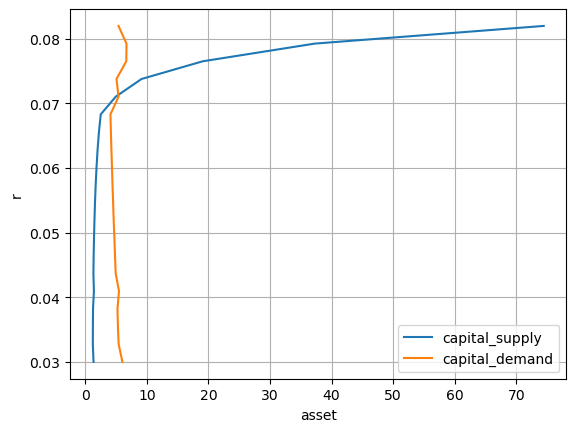

In [155]:
# Plot
plt.plot(k_supply,rgrid,label="capital_supply")
plt.plot(k_demand,rgrid,label="capital_demand")
# plt.title('capital market with w=0.275')
plt.ylabel('r')
plt.xlabel('asset')
plt.legend()
plt.grid(True)

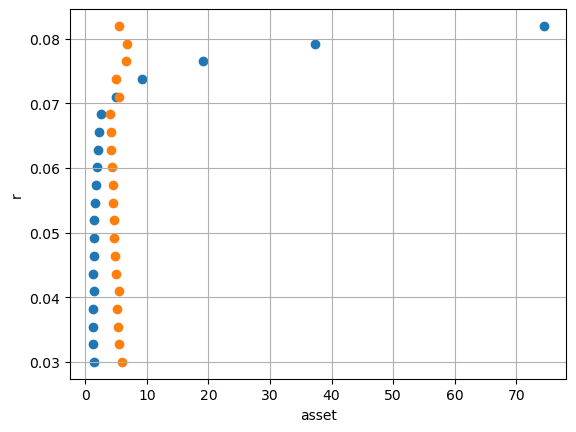

In [156]:
# Plot
plt.scatter(k_supply,rgrid,label="capital_supply")
plt.scatter(k_demand,rgrid,label="capital_demand")
# plt.title('capital market with w=0.275')
plt.ylabel('r')
plt.xlabel('asset')
# plt.legend()
plt.grid(True)
# plt.xlim(0,10)

In [42]:
rgrid

array([0.03      , 0.03273684, 0.03547368, 0.03821053, 0.04094737,
       0.04368421, 0.04642105, 0.04915789, 0.05189474, 0.05463158,
       0.05736842, 0.06010526, 0.06284211, 0.06557895, 0.06831579,
       0.07105263, 0.07378947, 0.07652632, 0.07926316, 0.082     ])

In [161]:
def r_update(p_s,tol):
    rmin=0.056
    rmax=0.0755
    r0=1/2*(rmin+rmax)
    error = np.inf
    count = 0
    max_iter = 1000
    while count < max_iter and error > tol:
        w = w_update(r0,p_s,1e-4)
        res_k = equilibrium_k(w,r0,p_s)
        if res_k < 0:
            rmin=r0
        else:
            rmax=r0
        r0 = 1/2*(rmin+rmax)
        error = np.abs(rmax-rmin)
        count = count + 1
    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {count} iterations.")
    return r0

In [162]:
from tqdm import tqdm

def service_curve(pmin, pmax, pgrid_number):
    pgrid = np.linspace(pmin, pmax, pgrid_number)
    s_supply = np.zeros(pgrid_number)
    s_demand = np.zeros(pgrid_number)
    for i in tqdm(range(pgrid_number)):
        p0 = pgrid[i]
        r = r_update(p0,1e-3)
        w = w_update(r,p0,1e-4)
        a_supply,a_demand,l_supply,l_demand,s_supply[i],s_demand[i]=capital_and_labor_and_service(w,r,p0) #capital 只是为了占位
    return pgrid, s_supply, s_demand

pgrid, service_supply, service_demand = service_curve(
    pmin=5, pmax=15, pgrid_number=16
)


  0%|          | 0/16 [00:00<?, ?it/s]

w= 1.4 r= 0.056 p_s= 5.0 labor suply= 0.9351835811388792 labor demand= 0.5940921735672917 res_l= 0.3410914075715875
w= 1.2999999999999998 r= 0.056 p_s= 5.0 labor suply= 0.8523007402644412 labor demand= 0.9883959128642709 res_l= -0.13609517259982962
w= 1.3499999999999999 r= 0.056 p_s= 5.0 labor suply= 0.8541821166250666 labor demand= 0.801217942133795 res_l= 0.052964174491271554
w= 1.3249999999999997 r= 0.056 p_s= 5.0 labor suply= 0.8541513396217562 labor demand= 0.8556166244884225 res_l= -0.0014652848666663054
w= 1.3375 r= 0.056 p_s= 5.0 labor suply= 0.8541767494378557 labor demand= 0.8280787334005385 res_l= 0.026098016037317207
w= 1.3312499999999998 r= 0.056 p_s= 5.0 labor suply= 0.8541687396541598 labor demand= 0.8417201926529044 res_l= 0.012448547001255417
w= 1.3281249999999998 r= 0.056 p_s= 5.0 labor suply= 0.8541543030412501 labor demand= 0.848824547700393 res_l= 0.005329755340857112
w= 1.3265624999999996 r= 0.056 p_s= 5.0 labor suply= 0.8541532745402084 labor demand= 0.8521996990

  6%|▋         | 1/16 [19:02<4:45:42, 1142.80s/it]

w= 1.4 r= 0.056 p_s= 5.666666666666667 labor suply= 0.935257876163462 labor demand= 0.5930836051663078 res_l= 0.34217427099715425
w= 1.2999999999999998 r= 0.056 p_s= 5.666666666666667 labor suply= 0.8523203007684564 labor demand= 0.9865707188079595 res_l= -0.1342504180395031
w= 1.3499999999999999 r= 0.056 p_s= 5.666666666666667 labor suply= 0.8542029222649179 labor demand= 0.7997777098921262 res_l= 0.05442521237279174
w= 1.3249999999999997 r= 0.056 p_s= 5.666666666666667 labor suply= 0.8541707870659484 labor demand= 0.8541094789555522 res_l= 6.130811039617434e-05
w= 1.3124999999999998 r= 0.056 p_s= 5.666666666666667 labor suply= 0.8523252687186592 labor demand= 0.9526582343559685 res_l= -0.10033296563730931
w= 1.3187499999999996 r= 0.056 p_s= 5.666666666666667 labor suply= 0.8540071237768877 labor demand= 0.8732564909278968 res_l= -0.01924936715100911
w= 1.3218749999999997 r= 0.056 p_s= 5.666666666666667 labor suply= 0.8541678569597774 labor demand= 0.8609966773231941 res_l= -0.0068288

 12%|█▎        | 2/16 [38:09<4:27:08, 1144.87s/it]

w= 1.4 r= 0.056 p_s= 6.333333333333333 labor suply= 0.9352979367757849 labor demand= 0.5923455421703775 res_l= 0.3429523946054074
w= 1.2999999999999998 r= 0.056 p_s= 6.333333333333333 labor suply= 0.8523274216023723 labor demand= 0.9851520218589821 res_l= -0.1328246002566098
w= 1.3499999999999999 r= 0.056 p_s= 6.333333333333333 labor suply= 0.8542192923845465 labor demand= 0.7986231378270101 res_l= 0.055596154557536415
w= 1.3249999999999997 r= 0.056 p_s= 6.333333333333333 labor suply= 0.8541824025654401 labor demand= 0.8531608312943388 res_l= 0.0010215712711012515
w= 1.3124999999999998 r= 0.056 p_s= 6.333333333333333 labor suply= 0.8523420438050674 labor demand= 0.9520111313143295 res_l= -0.09966908750926207
w= 1.3187499999999996 r= 0.056 p_s= 6.333333333333333 labor suply= 0.8540289558531563 labor demand= 0.8716564526078615 res_l= -0.017627496754705207
w= 1.3218749999999997 r= 0.056 p_s= 6.333333333333333 labor suply= 0.8541797433371499 labor demand= 0.8599433117351574 res_l= -0.00576

 19%|█▉        | 3/16 [57:08<4:07:32, 1142.49s/it]

w= 1.4 r= 0.056 p_s= 7.0 labor suply= 0.9353707988228267 labor demand= 0.5910894852387715 res_l= 0.3442813135840552
w= 1.2999999999999998 r= 0.056 p_s= 7.0 labor suply= 0.8523450445652595 labor demand= 0.9841007808755134 res_l= -0.13175573631025395
w= 1.3499999999999999 r= 0.056 p_s= 7.0 labor suply= 0.8542130322932155 labor demand= 0.798384696915246 res_l= 0.055828335377969496
w= 1.3249999999999997 r= 0.056 p_s= 7.0 labor suply= 0.8541829714670829 labor demand= 0.8526149409217009 res_l= 0.0015680305453820154
w= 1.3124999999999998 r= 0.056 p_s= 7.0 labor suply= 0.8523463752439787 labor demand= 0.9508618636568313 res_l= -0.09851548841285263
w= 1.3187499999999996 r= 0.056 p_s= 7.0 labor suply= 0.8540391905880143 labor demand= 0.8707859593849056 res_l= -0.016746768796891298
w= 1.3218749999999997 r= 0.056 p_s= 7.0 labor suply= 0.854180185781451 labor demand= 0.8592826787036127 res_l= -0.005102492922161694
w= 1.3234374999999998 r= 0.056 p_s= 7.0 labor suply= 0.8541816146417499 labor demand=

 25%|██▌       | 4/16 [1:16:11<3:48:30, 1142.54s/it]

w= 1.4 r= 0.056 p_s= 7.666666666666666 labor suply= 0.9353780567014276 labor demand= 0.5907767287664446 res_l= 0.344601327934983
w= 1.2999999999999998 r= 0.056 p_s= 7.666666666666666 labor suply= 0.8523509925749861 labor demand= 0.9828407616765231 res_l= -0.13048976910153698
w= 1.3499999999999999 r= 0.056 p_s= 7.666666666666666 labor suply= 0.854229852643285 labor demand= 0.7970567839747613 res_l= 0.057173068668523674
w= 1.3249999999999997 r= 0.056 p_s= 7.666666666666666 labor suply= 0.8541883436286057 labor demand= 0.8520234204904096 res_l= 0.002164923138196162
w= 1.3124999999999998 r= 0.056 p_s= 7.666666666666666 labor suply= 0.852365463293637 labor demand= 0.949650586347579 res_l= -0.09728512305394199
w= 1.3187499999999996 r= 0.056 p_s= 7.666666666666666 labor suply= 0.8540343182060901 labor demand= 0.8703996693712349 res_l= -0.016365351165144815
w= 1.3218749999999997 r= 0.056 p_s= 7.666666666666666 labor suply= 0.8541857919855167 labor demand= 0.8586660791289058 res_l= -0.004480287

 31%|███▏      | 5/16 [1:35:22<3:30:03, 1145.75s/it]

w= 1.4 r= 0.056 p_s= 8.333333333333332 labor suply= 0.9354617143120031 labor demand= 0.589635752877108 res_l= 0.3458259614348951
w= 1.2999999999999998 r= 0.056 p_s= 8.333333333333332 labor suply= 0.8523666009433899 labor demand= 0.9814439697922854 res_l= -0.12907736884889554
w= 1.3499999999999999 r= 0.056 p_s= 8.333333333333332 labor suply= 0.8542380302001145 labor demand= 0.7961912047006817 res_l= 0.05804682549943274
w= 1.3249999999999997 r= 0.056 p_s= 8.333333333333332 labor suply= 0.8542054374170961 labor demand= 0.8506431021218956 res_l= 0.0035623352952004472
w= 1.3124999999999998 r= 0.056 p_s= 8.333333333333332 labor suply= 0.8523670053583721 labor demand= 0.949021067432519 res_l= -0.09665406207414695
w= 1.3187499999999996 r= 0.056 p_s= 8.333333333333332 labor suply= 0.8540506074321453 labor demand= 0.8693007106912315 res_l= -0.015250103259086156
w= 1.3218749999999997 r= 0.056 p_s= 8.333333333333332 labor suply= 0.8542021714757089 labor demand= 0.8576409730604052 res_l= -0.0034388

 38%|███▊      | 6/16 [1:54:29<3:10:59, 1145.92s/it]

w= 1.4 r= 0.056 p_s= 9.0 labor suply= 0.9354744392379224 labor demand= 0.5890832758972633 res_l= 0.3463911633406591
w= 1.2999999999999998 r= 0.056 p_s= 9.0 labor suply= 0.8523594669678486 labor demand= 0.9812815274666025 res_l= -0.12892206049875388
w= 1.3499999999999999 r= 0.056 p_s= 9.0 labor suply= 0.8542377253981818 labor demand= 0.7963590871794364 res_l= 0.05787863821874539
w= 1.3249999999999997 r= 0.056 p_s= 9.0 labor suply= 0.8542129644229881 labor demand= 0.8499940339155497 res_l= 0.004218930507438379
w= 1.3124999999999998 r= 0.056 p_s= 9.0 labor suply= 0.8523748642867276 labor demand= 0.9481353304081354 res_l= -0.09576046612140776
w= 1.3187499999999996 r= 0.056 p_s= 9.0 labor suply= 0.8540586872823928 labor demand= 0.8685491862750644 res_l= -0.01449049899267163
w= 1.3218749999999997 r= 0.056 p_s= 9.0 labor suply= 0.8542099742378764 labor demand= 0.8568722197964479 res_l= -0.00266224555857153
w= 1.3234374999999998 r= 0.056 p_s= 9.0 labor suply= 0.8542123003828904 labor demand= 0

 44%|████▍     | 7/16 [2:13:32<2:51:47, 1145.26s/it]

w= 1.4 r= 0.056 p_s= 9.666666666666666 labor suply= 0.9355001276815703 labor demand= 0.588626497550231 res_l= 0.3468736301313393
w= 1.2999999999999998 r= 0.056 p_s= 9.666666666666666 labor suply= 0.8523737308919017 labor demand= 0.9800832515092881 res_l= -0.12770952061738639
w= 1.3499999999999999 r= 0.056 p_s= 9.666666666666666 labor suply= 0.8542544632302791 labor demand= 0.795533947951373 res_l= 0.058720515278906094
w= 1.3249999999999997 r= 0.056 p_s= 9.666666666666666 labor suply= 0.8542118788242429 labor demand= 0.8494325157574537 res_l= 0.004779363066789166
w= 1.3124999999999998 r= 0.056 p_s= 9.666666666666666 labor suply= 0.8523896447721667 labor demand= 0.9469363935691443 res_l= -0.09454674879697755
w= 1.3187499999999996 r= 0.056 p_s= 9.666666666666666 labor suply= 0.8540715048154847 labor demand= 0.8684645051863518 res_l= -0.014393000370867104
w= 1.3218749999999997 r= 0.056 p_s= 9.666666666666666 labor suply= 0.8542257311809643 labor demand= 0.8556535675371734 res_l= -0.0014278

 50%|█████     | 8/16 [2:32:44<2:32:58, 1147.36s/it]

w= 1.4 r= 0.056 p_s= 10.333333333333332 labor suply= 0.9355483552876454 labor demand= 0.587982004468329 res_l= 0.3475663508193163
w= 1.2999999999999998 r= 0.056 p_s= 10.333333333333332 labor suply= 0.8523847261261382 labor demand= 0.9793070300874561 res_l= -0.12692230396131787
w= 1.3499999999999999 r= 0.056 p_s= 10.333333333333332 labor suply= 0.8542518283631466 labor demand= 0.7951445540604634 res_l= 0.059107274302683255
w= 1.3249999999999997 r= 0.056 p_s= 10.333333333333332 labor suply= 0.8542256299370966 labor demand= 0.8486117984993872 res_l= 0.005613831437709438
w= 1.3124999999999998 r= 0.056 p_s= 10.333333333333332 labor suply= 0.852384383147489 labor demand= 0.9465404459384709 res_l= -0.09415606279098188
w= 1.3187499999999996 r= 0.056 p_s= 10.333333333333332 labor suply= 0.8540652318062525 labor demand= 0.8682611088417841 res_l= -0.014195877035531601
w= 1.3218749999999997 r= 0.056 p_s= 10.333333333333332 labor suply= 0.854218232561196 labor demand= 0.856094283648529 res_l= -0.00

 56%|█████▋    | 9/16 [2:51:51<2:13:50, 1147.16s/it]

w= 1.4 r= 0.056 p_s= 11.0 labor suply= 0.9355693905389206 labor demand= 0.5879112270155509 res_l= 0.34765816352336976
w= 1.2999999999999998 r= 0.056 p_s= 11.0 labor suply= 0.8523871436141794 labor demand= 0.9799465789139272 res_l= -0.12755943529974778
w= 1.3499999999999999 r= 0.056 p_s= 11.0 labor suply= 0.854252341325916 labor demand= 0.7947155650198408 res_l= 0.059536776306075234
w= 1.3249999999999997 r= 0.056 p_s= 11.0 labor suply= 0.8542264627558788 labor demand= 0.8489834149883249 res_l= 0.00524304776755391
w= 1.3124999999999998 r= 0.056 p_s= 11.0 labor suply= 0.8523896664603251 labor demand= 0.9462498222250842 res_l= -0.09386015576475915
w= 1.3187499999999996 r= 0.056 p_s= 11.0 labor suply= 0.8540721484526168 labor demand= 0.8673361022307526 res_l= -0.013263953778135829
w= 1.3218749999999997 r= 0.056 p_s= 11.0 labor suply= 0.8542240093159917 labor demand= 0.8556596266092313 res_l= -0.0014356172932395994
w= 1.3234374999999998 r= 0.056 p_s= 11.0 labor suply= 0.8542253346547664 labo

 62%|██████▎   | 10/16 [3:10:54<1:54:35, 1145.98s/it]

w= 1.4 r= 0.056 p_s= 11.666666666666666 labor suply= 0.9355559696463015 labor demand= 0.5877406517380817 res_l= 0.34781531790821985
w= 1.2999999999999998 r= 0.056 p_s= 11.666666666666666 labor suply= 0.8523798491919716 labor demand= 0.9804527338107608 res_l= -0.12807288461878918
w= 1.3499999999999999 r= 0.056 p_s= 11.666666666666666 labor suply= 0.8542684346604378 labor demand= 0.7937691511068368 res_l= 0.06049928355360101
w= 1.3249999999999997 r= 0.056 p_s= 11.666666666666666 labor suply= 0.8542343996821249 labor demand= 0.8481091094812003 res_l= 0.00612529020092456
w= 1.3124999999999998 r= 0.056 p_s= 11.666666666666666 labor suply= 0.8523980687209279 labor demand= 0.9454536826297957 res_l= -0.09305561390886774
w= 1.3187499999999996 r= 0.056 p_s= 11.666666666666666 labor suply= 0.8540795518904443 labor demand= 0.8667536348850672 res_l= -0.012674082994622915
w= 1.3218749999999997 r= 0.056 p_s= 11.666666666666666 labor suply= 0.8542321204760391 labor demand= 0.85499292846331 res_l= -0.0

 69%|██████▉   | 11/16 [3:30:06<1:35:38, 1147.74s/it]

w= 1.4 r= 0.056 p_s= 12.333333333333332 labor suply= 0.935579174209774 labor demand= 0.5875161950320646 res_l= 0.34806297917770934
w= 1.2999999999999998 r= 0.056 p_s= 12.333333333333332 labor suply= 0.8523863425840162 labor demand= 0.9797571820937441 res_l= -0.12737083950972783
w= 1.3499999999999999 r= 0.056 p_s= 12.333333333333332 labor suply= 0.8542720000041234 labor demand= 0.7934780663095922 res_l= 0.06079393369453123
w= 1.3249999999999997 r= 0.056 p_s= 12.333333333333332 labor suply= 0.8542308160132055 labor demand= 0.8477845559330771 res_l= 0.006446260080128385
w= 1.3124999999999998 r= 0.056 p_s= 12.333333333333332 labor suply= 0.8524109958746352 labor demand= 0.9444480155227228 res_l= -0.09203701964808764
w= 1.3187499999999996 r= 0.056 p_s= 12.333333333333332 labor suply= 0.8540923332394602 labor demand= 0.8659646826810211 res_l= -0.011872349441560903
w= 1.3218749999999997 r= 0.056 p_s= 12.333333333333332 labor suply= 0.8542441926143391 labor demand= 0.8541916754342178 res_l= 5.

 75%|███████▌  | 12/16 [3:49:15<1:16:32, 1148.21s/it]

w= 1.4 r= 0.056 p_s= 13.0 labor suply= 0.9355973129773092 labor demand= 0.5870993629503423 res_l= 0.34849795002696693
w= 1.2999999999999998 r= 0.056 p_s= 13.0 labor suply= 0.8523915124470121 labor demand= 0.9791297639529187 res_l= -0.12673825150590667
w= 1.3499999999999999 r= 0.056 p_s= 13.0 labor suply= 0.8542773717142681 labor demand= 0.7928796727065566 res_l= 0.061397699007711526
w= 1.3249999999999997 r= 0.056 p_s= 13.0 labor suply= 0.8542488527963836 labor demand= 0.8468208922552359 res_l= 0.0074279605411476934
w= 1.3124999999999998 r= 0.056 p_s= 13.0 labor suply= 0.8524129670550491 labor demand= 0.9439439296091354 res_l= -0.09153096255408633
w= 1.3187499999999996 r= 0.056 p_s= 13.0 labor suply= 0.8540937708018302 labor demand= 0.8656360758998982 res_l= -0.011542305098067973
w= 1.3218749999999997 r= 0.056 p_s= 13.0 labor suply= 0.8542458927335994 labor demand= 0.8536191091423637 res_l= 0.0006267835912356912
w= 1.3203124999999996 r= 0.056 p_s= 13.0 labor suply= 0.8542448072733098 la

 81%|████████▏ | 13/16 [4:09:03<58:00, 1160.25s/it]  

w= 1.4 r= 0.056 p_s= 13.666666666666666 labor suply= 0.9356487284999238 labor demand= 0.5864344228871867 res_l= 0.34921430561273703
w= 1.2999999999999998 r= 0.056 p_s= 13.666666666666666 labor suply= 0.8523990374383512 labor demand= 0.9788730496943727 res_l= -0.1264740122560215
w= 1.3499999999999999 r= 0.056 p_s= 13.666666666666666 labor suply= 0.854266750209721 labor demand= 0.7929724436518822 res_l= 0.06129430655783874
w= 1.3249999999999997 r= 0.056 p_s= 13.666666666666666 labor suply= 0.8542415421047564 labor demand= 0.846809342927535 res_l= 0.007432199177221488
w= 1.3124999999999998 r= 0.056 p_s= 13.666666666666666 labor suply= 0.8524215506083114 labor demand= 0.943258673750416 res_l= -0.09083712314210468
w= 1.3187499999999996 r= 0.056 p_s= 13.666666666666666 labor suply= 0.8540857561036794 labor demand= 0.8660807257104038 res_l= -0.011994969606724415
w= 1.3218749999999997 r= 0.056 p_s= 13.666666666666666 labor suply= 0.8542388313280344 labor demand= 0.8534834108886675 res_l= 0.000

 88%|████████▊ | 14/16 [4:28:24<38:40, 1160.32s/it]

w= 1.4 r= 0.056 p_s= 14.333333333333332 labor suply= 0.935644017043637 labor demand= 0.5866878336984468 res_l= 0.3489561833451902
w= 1.2999999999999998 r= 0.056 p_s= 14.333333333333332 labor suply= 0.8524025336355594 labor demand= 0.9783634806381624 res_l= -0.12596094700260296
w= 1.3499999999999999 r= 0.056 p_s= 14.333333333333332 labor suply= 0.8542838452200915 labor demand= 0.7922876033112908 res_l= 0.06199624190880071
w= 1.3249999999999997 r= 0.056 p_s= 14.333333333333332 labor suply= 0.854241619429587 labor demand= 0.8464152244877348 res_l= 0.007826394941852222
w= 1.3124999999999998 r= 0.056 p_s= 14.333333333333332 labor suply= 0.8524196097686677 labor demand= 0.9431994179765414 res_l= -0.09077980820787368
w= 1.3187499999999996 r= 0.056 p_s= 14.333333333333332 labor suply= 0.8540997153421614 labor demand= 0.865382931581288 res_l= -0.011283216239126537
w= 1.3218749999999997 r= 0.056 p_s= 14.333333333333332 labor suply= 0.8542386223545357 labor demand= 0.8535617539126419 res_l= 0.000

 94%|█████████▍| 15/16 [4:47:36<19:17, 1157.86s/it]

w= 1.4 r= 0.056 p_s= 15.0 labor suply= 0.935666885069578 labor demand= 0.5863328003933502 res_l= 0.34933408467622773
w= 1.2999999999999998 r= 0.056 p_s= 15.0 labor suply= 0.8524088933446017 labor demand= 0.9778062067262759 res_l= -0.12539731338167426
w= 1.3499999999999999 r= 0.056 p_s= 15.0 labor suply= 0.8542709073336656 labor demand= 0.7924883535311521 res_l= 0.06178255380251352
w= 1.3249999999999997 r= 0.056 p_s= 15.0 labor suply= 0.8542460976891229 labor demand= 0.84592489619873 res_l= 0.008321201490392838
w= 1.3124999999999998 r= 0.056 p_s= 15.0 labor suply= 0.8524247214259104 labor demand= 0.9431610472914205 res_l= -0.09073632586551006
w= 1.3187499999999996 r= 0.056 p_s= 15.0 labor suply= 0.8540904077871081 labor demand= 0.8653181359541673 res_l= -0.011227728167059192
w= 1.3218749999999997 r= 0.056 p_s= 15.0 labor suply= 0.8542431296368089 labor demand= 0.8534338565257633 res_l= 0.0008092731110456164
w= 1.3203124999999996 r= 0.056 p_s= 15.0 labor suply= 0.8542413771897597 labor d

100%|██████████| 16/16 [5:06:50<00:00, 1150.67s/it]


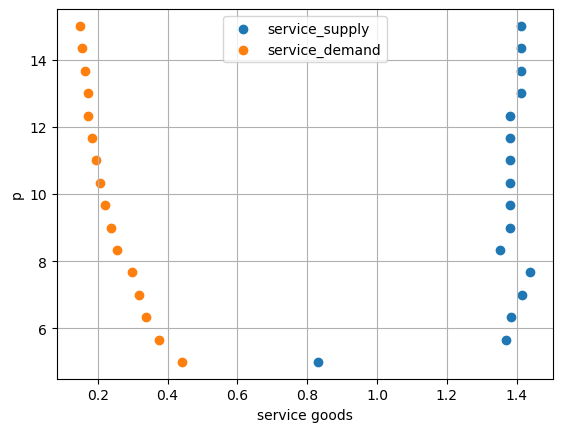

In [163]:
# Plot
plt.scatter(service_supply,pgrid,label="service_supply")
plt.scatter(service_demand,pgrid,label="service_demand")
# plt.title('service market with w=0.275')
# plt.axhline(ps_eq,color='r',linestyle='--',label='p_eq')
plt.ylabel('p')
plt.xlabel('service goods')
plt.legend()
plt.grid(True)

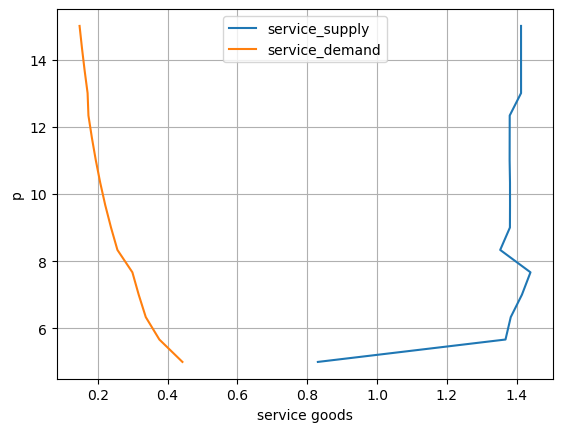

In [164]:
plt.plot(service_supply,pgrid,label="service_supply")
plt.plot(service_demand,pgrid,label="service_demand")
# plt.title('service market with w=0.275')
# plt.axhline(ps_eq,color='r',linestyle='--',label='p_eq')
plt.ylabel('p')
plt.xlabel('service goods')
plt.legend()
plt.grid(True)

In [165]:
service_supply-service_demand

array([0.38803041, 0.99162909, 1.0455219 , 1.09781759, 1.14044415,
       1.09659085, 1.14281093, 1.15960586, 1.17391567, 1.18545799,
       1.19676493, 1.20684695, 1.24179908, 1.25017683, 1.25777958,
       1.2646992 ])

In [172]:
r = r_update(1,1e-3)
w = w_update(r,2,1e-4)
equilibrium_s(w,r,1)

w= 1.4 r= 0.056 p_s= 1 labor suply= 0.9344394093640692 labor demand= 0.6052659941808191 res_l= 0.32917341518325016
w= 1.2999999999999998 r= 0.056 p_s= 1 labor suply= 0.852129406079255 labor demand= 1.005551001603404 res_l= -0.1534215955241489
w= 1.3499999999999999 r= 0.056 p_s= 1 labor suply= 0.854041549806505 labor demand= 0.8130817617352575 res_l= 0.04095978807124756
w= 1.3249999999999997 r= 0.056 p_s= 1 labor suply= 0.8539995628019329 labor demand= 0.8700929159500775 res_l= -0.01609335314814464
w= 1.3375 r= 0.056 p_s= 1 labor suply= 0.8540163191527389 labor demand= 0.8418075541522627 res_l= 0.012208765000476185
w= 1.3312499999999998 r= 0.056 p_s= 1 labor suply= 0.8540171661505624 labor demand= 0.8560721195430455 res_l= -0.002054953392483072
w= 1.3343749999999999 r= 0.056 p_s= 1 labor suply= 0.8540247144341024 labor demand= 0.8482051219322704 res_l= 0.0058195925018320604
w= 1.3328124999999997 r= 0.056 p_s= 1 labor suply= 0.8540213665532095 labor demand= 0.8520778132054488 res_l= 0.00

-0.469858181609919

## Find P

In [173]:
def p_iteration(tol):
    pmin=1
    pmax=2
    p0=0.5*(pmin+pmax)
    error = np.inf
    count = 0
    max_iter = 1000
    while count < max_iter and error > tol:
        r = r_update(p0,1e-4)
        w = w_update(r,p0,1e-4)
        res = equilibrium_s(w,r,p0)
        if res > 0:
            pmax = p0
        else:
            pmin = p0
        p0=0.5*(pmin+pmax)
        error = np.abs(pmax-pmin)
        count = count + 1
        print('pmin=',pmin,'pmax=',pmax,'p0=',p0,'r=',r,'w=',w,'iteration times=',count,'res=',res)
    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {count} iterations.")
    return p0
   

In [174]:
start_time = timeit.default_timer()
ps_eq = p_iteration(1e-4)
print("The time difference is :", timeit.default_timer() - start_time)

w= 1.4 r= 0.056 p_s= 1.5 labor suply= 0.9346066649532687 labor demand= 0.6024872183589699 res_l= 0.3321194465942988
w= 1.2999999999999998 r= 0.056 p_s= 1.5 labor suply= 0.8521661640695807 labor demand= 1.001628016911709 res_l= -0.14946185284212843
w= 1.3499999999999999 r= 0.056 p_s= 1.5 labor suply= 0.8540716121484869 labor demand= 0.8104575170238574 res_l= 0.04361409512462955
w= 1.3249999999999997 r= 0.056 p_s= 1.5 labor suply= 0.8540295854580107 labor demand= 0.8674285889550089 res_l= -0.013399003496998185
w= 1.3375 r= 0.056 p_s= 1.5 labor suply= 0.8540464660549141 labor demand= 0.8390787957614408 res_l= 0.014967670293473234
w= 1.3312499999999998 r= 0.056 p_s= 1.5 labor suply= 0.8540478402997257 labor demand= 0.8534392721044689 res_l= 0.0006085681952567867
w= 1.3281249999999998 r= 0.056 p_s= 1.5 labor suply= 0.8540342506871075 labor demand= 0.8602569959433207 res_l= -0.006222745256213247
w= 1.3296875 r= 0.056 p_s= 1.5 labor suply= 0.8540359184580475 labor demand= 0.8568990778111697 r

SystemError: CPUDispatcher(<function V_update at 0x000001FC311C19E0>) returned a result with an exception set

In [176]:
r_eq = r_update(1.47802734375 ,1e-5)

w= 1.4 r= 0.056 p_s= 1.47802734375 labor suply= 0.9346050956016086 labor demand= 0.6025045225344825 res_l= 0.33210057306712615
w= 1.2999999999999998 r= 0.056 p_s= 1.47802734375 labor suply= 0.8521651565347376 labor demand= 1.002001477398202 res_l= -0.14983632086346443
w= 1.3499999999999999 r= 0.056 p_s= 1.47802734375 labor suply= 0.8540710141757314 labor demand= 0.8104855774096651 res_l= 0.0435854367660663
w= 1.3249999999999997 r= 0.056 p_s= 1.47802734375 labor suply= 0.8540292439323712 labor demand= 0.8674464350971915 res_l= -0.013417191164820319
w= 1.3375 r= 0.056 p_s= 1.47802734375 labor suply= 0.8540588230311479 labor demand= 0.8386514179495871 res_l= 0.015407405081560799
w= 1.3312499999999998 r= 0.056 p_s= 1.47802734375 labor suply= 0.854046882628617 labor demand= 0.8535379870311812 res_l= 0.0005088955974358322
w= 1.3281249999999998 r= 0.056 p_s= 1.47802734375 labor suply= 0.8540336455235257 labor demand= 0.8602874305235733 res_l= -0.006253785000047585
w= 1.3296875 r= 0.056 p_s= 1

In [177]:
w_eq = w_update(r_eq,1.47802734375 ,1e-5)

w= 1.4 r= 0.067067138671875 p_s= 1.47802734375 labor suply= 0.8417758937367569 labor demand= 1.247748700019808 res_l= -0.4059728062830511
w= 1.5 r= 0.067067138671875 p_s= 1.47802734375 labor suply= 0.8502638080416731 labor demand= 0.8352668916263764 res_l= 0.014996916415296768
w= 1.45 r= 0.067067138671875 p_s= 1.47802734375 labor suply= 0.8466138114646354 labor demand= 1.0134612384376687 res_l= -0.16684742697303323
w= 1.475 r= 0.067067138671875 p_s= 1.47802734375 labor suply= 0.8466447809178497 labor demand= 0.9577351260625222 res_l= -0.11109034514467253
w= 1.4875 r= 0.067067138671875 p_s= 1.47802734375 labor suply= 0.8466840334045731 labor demand= 0.9547547407123508 res_l= -0.10807070730777768
w= 1.49375 r= 0.067067138671875 p_s= 1.47802734375 labor suply= 0.8502577057604829 labor demand= 0.8469299494126924 res_l= 0.003327756347790478
w= 1.490625 r= 0.067067138671875 p_s= 1.47802734375 labor suply= 0.8468303023292507 labor demand= 0.9483100595212578 res_l= -0.10147975719200708
w= 1.49

100%|██████████| 50/50 [11:11<00:00, 13.42s/it]


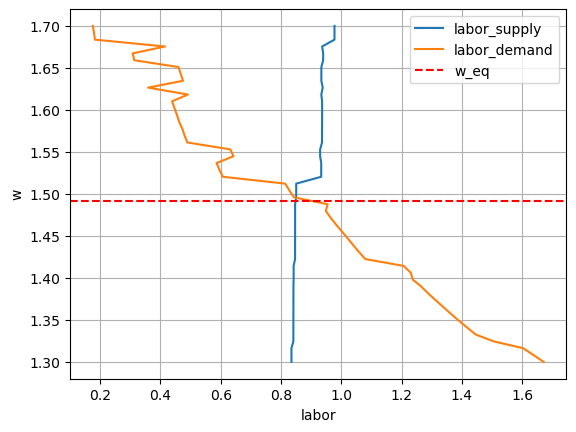

In [182]:
from tqdm import tqdm

def labor_curve(n_a, wmin, wmax, wgrid_number,r,p_s):
    wgrid = np.linspace(wmin, wmax, wgrid_number)
    l_supply = np.zeros(wgrid_number)
    l_demand = np.zeros(wgrid_number)
    for i in tqdm(range(wgrid_number)):
        w0 = wgrid[i]
        capital_supply,capital_demand,l_supply[i],l_demand[i],service_supply,service_demand=capital_and_labor_and_service(w0,r,p_s) #capital 只是为了占位
    return wgrid, l_supply, l_demand

wgrid, labor_supply, labor_demand = labor_curve(
    n_a=n_k, wmin=1.3, wmax=1.7 ,wgrid_number=50,r=r_eq,p_s=1.47802734375 
)
# Plot
plt.plot(labor_supply,wgrid,label="labor_supply")
plt.plot(labor_demand,wgrid,label="labor_demand")
# plt.title('labor market with r=0.08')
plt.axhline(w_eq,color='r',linestyle='--',label='w_eq')
plt.ylabel('w')
plt.xlabel('labor')
plt.legend()
plt.grid(True)

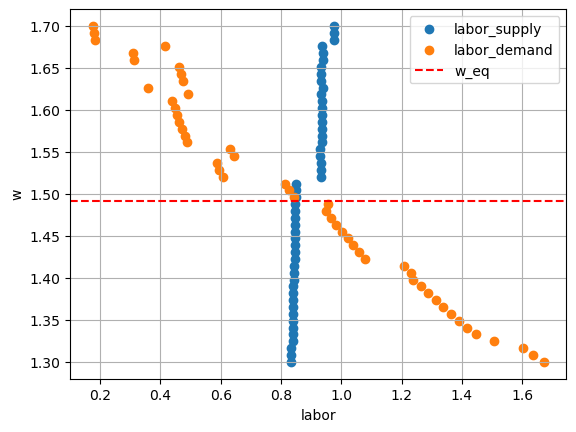

In [183]:
plt.scatter(labor_supply,wgrid,label="labor_supply")
plt.scatter(labor_demand,wgrid,label="labor_demand")
# plt.title('labor market with r=0.08')
plt.axhline(w_eq,color='r',linestyle='--',label='w_eq')
plt.ylabel('w')
plt.xlabel('labor')
plt.legend()
plt.grid(True)

100%|██████████| 50/50 [10:53<00:00, 13.06s/it]


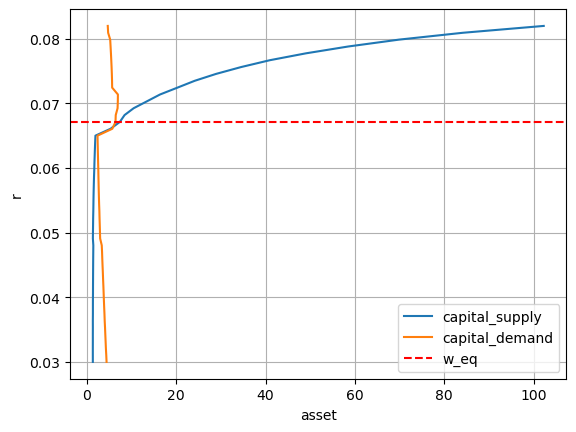

In [184]:
from tqdm import tqdm

def capital_curve(n_a, rmin, rmax, rgrid_number,w,p_s):
    rgrid = np.linspace(rmin, rmax, rgrid_number)
    a_supply = np.zeros(rgrid_number)
    a_demand = np.zeros(rgrid_number)
    for i in tqdm(range(rgrid_number)):
        r0 = rgrid[i]
        a_supply[i],a_demand[i],l_supply,l_demand,service_supply,service_demand=capital_and_labor_and_service(w,r0,p_s) #capital 只是为了占位
    return rgrid, a_supply, a_demand

rgrid, capital_supply, capital_demand = capital_curve(
    n_a=n_k, rmin=0.03, rmax=0.082, rgrid_number=50,w=w_eq,p_s=1.47802734375 
)
# Plot
plt.plot(capital_supply,rgrid,label="capital_supply")
plt.plot(capital_demand,rgrid,label="capital_demand")
# plt.title('capital market with w=0.275')
plt.axhline(r_eq,color='r',linestyle='--',label='w_eq')
plt.ylabel('r')
plt.xlabel('asset')
plt.legend()
plt.grid(True)

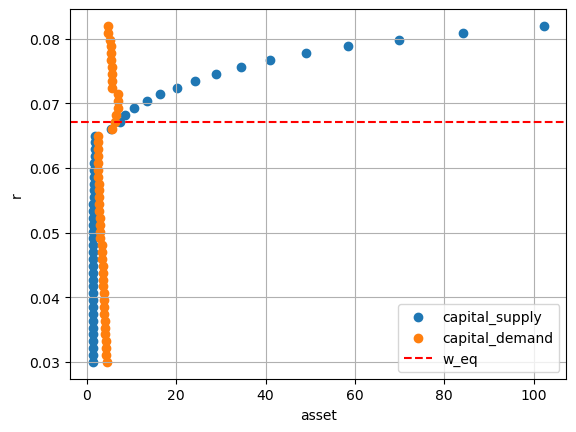

In [185]:
plt.scatter(capital_supply,rgrid,label="capital_supply")
plt.scatter(capital_demand,rgrid,label="capital_demand")
# plt.title('capital market with w=0.275')
plt.axhline(r_eq,color='r',linestyle='--',label='w_eq')
plt.ylabel('r')
plt.xlabel('asset')
plt.legend()
plt.grid(True)

In [186]:
from tqdm import tqdm

def service_curve(n_a, pmin, pmax, pgrid_number, w, r):
    pgrid = np.linspace(pmin, pmax, pgrid_number)
    s_supply = np.zeros(pgrid_number)
    s_demand = np.zeros(pgrid_number)
    for i in tqdm(range(pgrid_number)):
        p0 = pgrid[i]
        a_supply,a_demand,l_supply,l_demand,s_supply[i],s_demand[i]=capital_and_labor_and_service(w,r,p0) #capital 只是为了占位
    return pgrid, s_supply, s_demand

pgrid, service_supply, service_demand = service_curve(
    n_a=n_k, pmin=1, pmax=2, pgrid_number=50,w=w_eq,r=r_eq
)


100%|██████████| 50/50 [11:09<00:00, 13.40s/it]


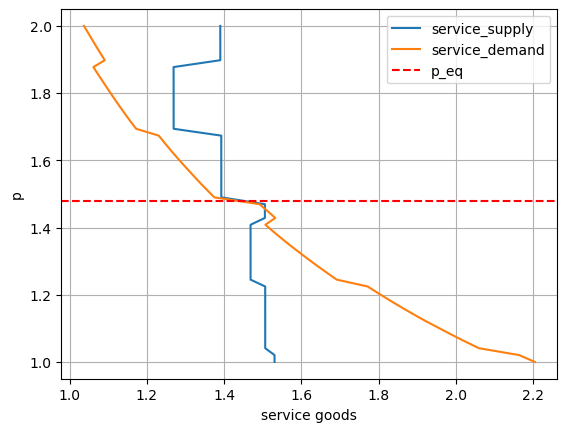

In [188]:
# Plot
plt.plot(service_supply,pgrid,label="service_supply")
plt.plot(service_demand,pgrid,label="service_demand")
# plt.title('service market with w=0.275')
plt.axhline(1.47802734375,color='r',linestyle='--',label='p_eq')
plt.ylabel('p')
plt.xlabel('service goods')
plt.legend()
plt.grid(True)

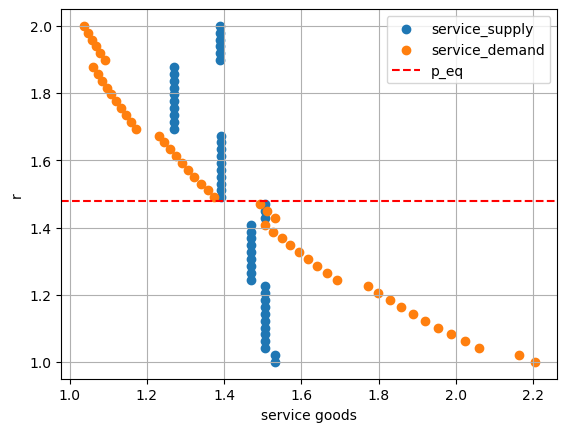

In [189]:
plt.scatter(service_supply,pgrid,label="service_supply")
plt.scatter(service_demand,pgrid,label="service_demand")
# plt.title('service market with w=0.275')
# plt.axhline(ps_eq,color='r',linestyle='--',label='p_eq')
plt.ylabel('r')
plt.xlabel('service goods')
plt.axhline(1.47802734375,color='r',linestyle='--',label='p_eq')
plt.legend()
plt.grid(True)

In [190]:
equilibrium_s(w_eq,r_eq,1.47802734375 )

w= 1.4919342041015624 r= 0.067067138671875 p_s= 1.47802734375 service suply= 1.5056943948722066 service demand= 1.4841182367893744 res_s= 0.021576158082832197


0.021576158082832197

In [191]:
equilibrium_k(w_eq,r_eq,1.47802734375 )

w= 1.4919342041015624 r= 0.067067138671875 p_s= 1.47802734375 capital supply= 7.352796837845994 capital demand= 6.399414886188415 res_k= 0.9533819516575788


0.9533819516575788

In [192]:
equilibrium_l(w_eq,r_eq,1.47802734375 )

w= 1.4919342041015624 r= 0.067067138671875 p_s= 1.47802734375 labor suply= 0.8468278230983346 labor demand= 0.9455805231953405 res_l= -0.09875270009700587


-0.09875270009700587

In [193]:
# Compute Demand and Supply in Capital Market
def capital_and_labor_and_service_and_manufacture(w,r,p_s):
    # initialize
    bound_matrix_s = s_capital_bound_matrix(w,r)
    bound_matrix_m = m_capital_bound_matrix(w,r)
    V0 = np.zeros((n_k, n_s*n_m))
    # iteration
    V_new,g,state_manufacture,state_service=V_iteration(V0,1e-7,w,r,p_s,bound_matrix_s,bound_matrix_m)
    # stable distribution
    Q=transQ_sparse(g)
    psi0 = np.ones((n_k * n_s*n_m))/(n_k * n_s*n_m)
    ss=sparse_stationary_distribution_iteration(Q,psi0,1e-4)
    tmp = ss.reshape((n_k, n_s*n_m))
    # a_dist=capital_marginal(ss)
    # compute demand and supply
    # capital_supply=np.dot(kgrid,a_dist)
    state_worker=np.ones((n_k, n_s*n_m))-state_manufacture-state_service
    R=r+delta
    # l = np.sum(state_worker*tmp)
    capital_supply_joint= np.zeros((n_k, n_s*n_m))
    capital_demand_joint= np.zeros((n_k, n_s*n_m))
    labor_supply_joint=np.zeros((n_k, n_s*n_m))
    labor_demand_joint= np.zeros((n_k, n_s*n_m))
    service_demand_joint = np.zeros((n_k, n_s*n_m))
    service_supply_joint = np.zeros((n_k, n_s*n_m))
    depreciation_joint = np.zeros((n_k,n_s*n_m))    
    m_supply_joint = np.zeros((n_k, n_s*n_m))   
    m_demand_joint = np.zeros((n_k, n_s*n_m)) 
    for i_k in range(n_k):
        for i_z in range(n_s*n_m):
            capital_supply_joint[i_k,i_z]=tmp[i_k,i_z]*g[i_k,i_z]
            labor_supply_joint[i_k,i_z] = state_worker[i_k,i_z]*tmp[i_k,i_z]
            i_s = i_z % n_s
            i_m = i_z // n_s
            k_m=m_capital_demand(i_k, i_z, w, r, bound_matrix_m)*state_manufacture[i_k,i_z]
            k_s=s_capital_demand(i_k, i_z, w, r, bound_matrix_s)*state_service[i_k,i_z]
            capital_demand_joint[i_k,i_z] = (k_m+k_s)*tmp[i_k,i_z]
            l_m = (theta*mgrid[i_m]*(k_m**alpha)/w)**(1/(1-theta))
            l_s = (theta*sgrid[i_s]*(k_s**alpha)/w)**(1/(1-theta))
            labor_demand_joint[i_k,i_z] = (l_m+l_s)*tmp[i_k,i_z]
            # service_demand_joint[i_k,i_z]=budget_worker(kgrid[i_k], g[i_k,i_z], w, r)*((p_s+((1-psi)/psi))**(-1))*tmp[i_k,i_z]
            service_demand_joint[i_k,i_z]=((p_s+((1-psi)/psi))**(-1))*tmp[i_k,i_z]*(budget_worker(kgrid[i_k], g[i_k,i_z], w, r)*state_worker[i_k,i_z]+budget_s(i_z,k_s,l_s,kgrid[i_k],g[i_k,i_z],w,r)*state_service[i_k,i_z]+budget_m(i_z,k_m,l_m,kgrid[i_k],g[i_k,i_z],w,r)*state_manufacture[i_k,i_z])
            service_supply_joint[i_k,i_z]=state_service[i_k,i_z]*tmp[i_k,i_z]*f_s(i_z,k_s,l_s)
            depreciation_joint[i_k,i_z]=state_manufacture[i_k,i_z]*tmp[i_k,i_z]*fc_m
            m_demand_joint[i_k,i_z]=service_demand_joint[i_k,i_z]*(1-psi)*(1-sigma)/(psi*(1-sigma))
            m_supply_joint[i_k,i_z]=state_manufacture[i_k,i_z]*tmp[i_k,i_z]*f_m(i_z,k_m,l_m)
    capital_supply=np.sum(capital_supply_joint)
    labor_supply=np.sum(labor_supply_joint)
    k_demand=np.sum(capital_demand_joint)
    l_demand=np.sum(labor_demand_joint)
    service_demand=np.sum(service_demand_joint)
    service_supply=np.sum(service_supply_joint)
    m_demand=np.sum(m_demand_joint)
    m_supply=np.sum(m_supply_joint)
    depreciation=np.sum(depreciation_joint)
    return capital_supply,k_demand,labor_supply,l_demand,service_supply,service_demand,m_demand,m_supply,depreciation


In [194]:
capital_supply,k_demand,labor_supply,l_demand,service_supply,service_demand,m_demand,m_supply,depreciation=capital_and_labor_and_service_and_manufacture(w_eq,r_eq,1.47802734375)

In [195]:
print('m-goods_demand=',m_demand,'m-goods_supply=',m_supply,'capital_supply=',capital_supply,'capital_demand=',k_demand,'fixed cost=',depreciation)


m-goods_demand= 0.1467809245176304 m-goods_supply= 1.37337484040816 capital_supply= 7.352796837845994 capital_demand= 6.399414886188415 fixed cost= 0.0717415018857231


In [196]:
m_supply-m_demand-delta*capital_supply-(1+r_eq)*depreciation

0.7088731064785485

In [197]:
m_supply-m_demand-delta*k_demand-(1+r_eq)*depreciation

0.7660760235780033